# **Bank Customer Churn Prediction**

*Done by:*


    Maor Ryngler
    Amit Tal Levi

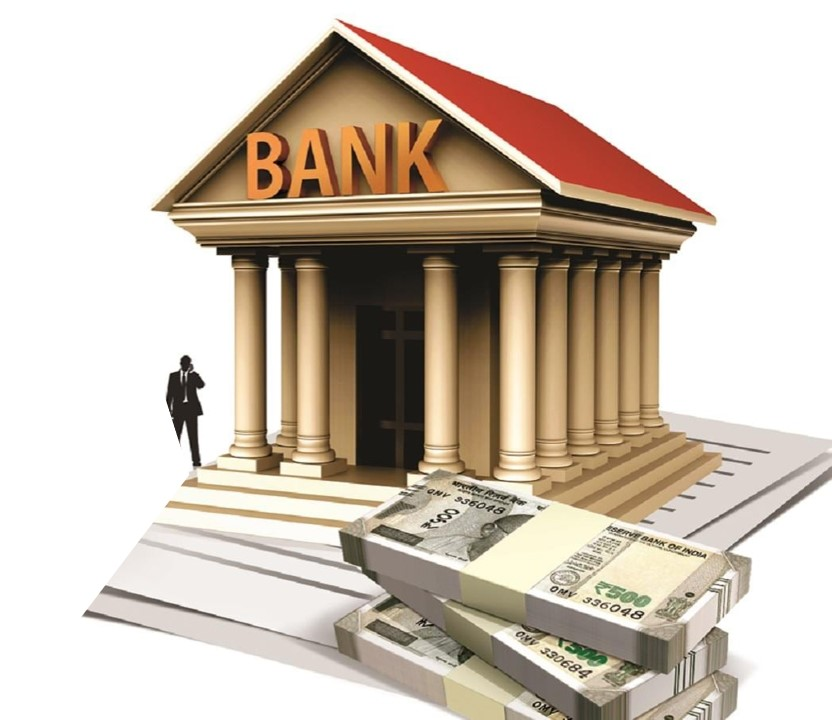

# **Introduction to Bank Customer Churn Prediction**

In today's banking sector, customer retention is crucial for sustained success. Customer churn, where customers terminate their relationship with a bank, poses a significant challenge. This project focuses on leveraging machine learning to predict churn based on historical customer data, including demographics, transactions, and interactions. By analyzing patterns and trends from historical customer data, banks can pinpoint which factors most significantly influence customer decisions to leave. This predictive insight allows financial institutions to implement targeted strategies to retain their customers, improving customer satisfaction and loyalty. Predicting churn offers benefits such as targeted retention strategies, cost reduction, enhanced customer experience, and long-term business growth.



In [1]:
# Importing Libraries

import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

import optuna
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, median_absolute_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import numpy as np
from scipy import stats




<b style="font-size: 18pt;color: #CCFFE5;">
import relevant libraries
</b>

**Getting & Exploring the Data**

**Load Data**

#We will use a small DS and then we will use a larger DS

In [2]:
# Reading .csv data file

#data = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
data = pd.read_csv("/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv")
#test_data = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")
#original_data = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

#see the shape of graph

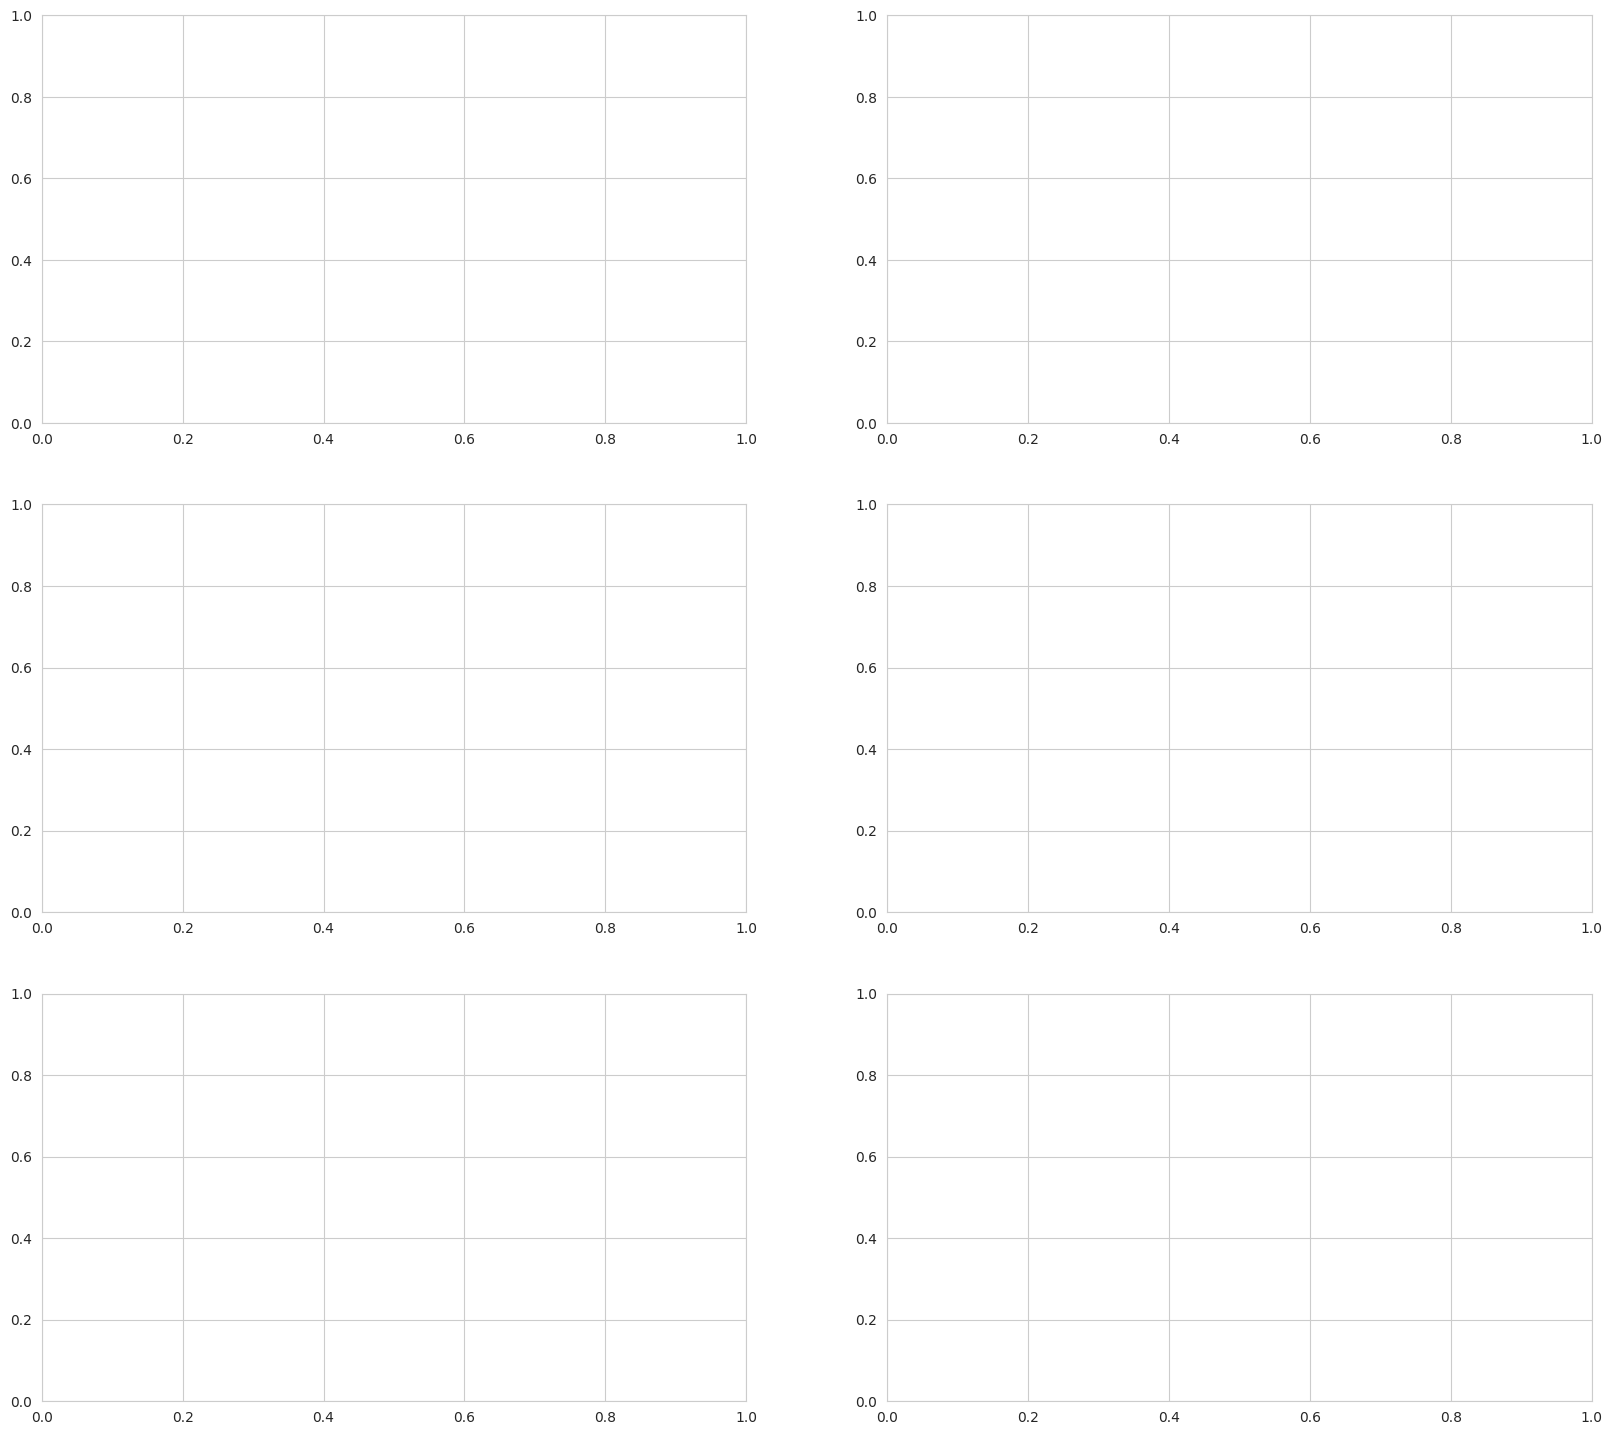

In [3]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Prepare figure layout
fig, axs = plt.subplots(3, 2, figsize=(20, 18))

In [4]:
data.shape

(10000, 14)

In [5]:
# Check columns list and missing values
data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

 :כדי לקבל מושג כללי על הגיוון של הנתונים בכל עמודה ולזהות עמודות עם כמות גדולה או קטנה של ערכים שונים.

In [6]:
# Get unique count for each variable
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

רלוונטיות לניתוח:  יכולה להפחית רעש ולמקד את הניתוח במשתנים עם משמעות סטטיסטית או פרקטית
הפשטת המודל: במודלים סטטיסטיים או מכונת למידה, עמודות עם נתונים שאינם תורמים לפתרון הבעיה עלולות להפריע ואף לגרום לתוצאות מוטעות. הפחתת ממדיות (feature reduction) על ידי הסרת עמודות יכולה לעזור להפשטת המודל ולשיפור הביצועים שלו.

data preoeration

In [7]:
# Drop the columns
data = data.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [8]:
# Review the top rows of what is left of the data frame
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
# Check variable data types
data.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [10]:
# Backup the data before working
data_frame = data
data_frame.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Data Exploration**

After backup is done, lest begin to investigate the "useful" data and decide, which data is more useful and which is less.

The graph below shows the Credits score destribution:

data['CreditScore'] = data['CreditScore'].replace([np.inf, -np.inf], np.nan)
פקודה זו מתקנת את נתוני דירוג האשראי (CreditScore) ב-DataFrame בשם data, על ידי החלפת כל הערכים שהם אינסוף חיובי או שלילי (np.inf, -np.inf) בערך NaN. זה יכול להיות חשוב למניעת שגיאות בחישובים נוספים שלא מטפלים כראוי בערכי אינסוף.
ניקוי והצגת נתונים, תוך שימוש בגרפיקה להמחשת התפלגות דירוגי האשראי בנתונים.


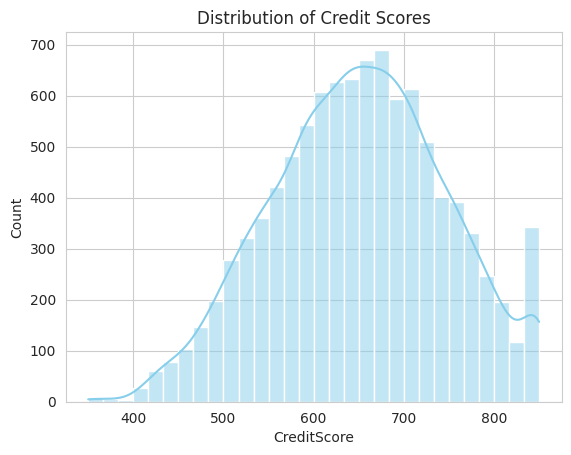

In [11]:
#The next row is to ignore the warning related to versions
import warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated", category=FutureWarning)
#To return the warning see the next row:
#warnings.filterwarnings("default", category=FutureWarning)

data['CreditScore'] = data['CreditScore'].replace([np.inf, -np.inf], np.nan)
# Plot the histogram
fig, axs = plt.subplots(1, 1)
sns.histplot(data['CreditScore'], bins=30, ax=axs, kde=True, color='skyblue')
axs.set_title('Distribution of Credit Scores')
plt.show()

The code below represents the Geographical values destribution for customers:

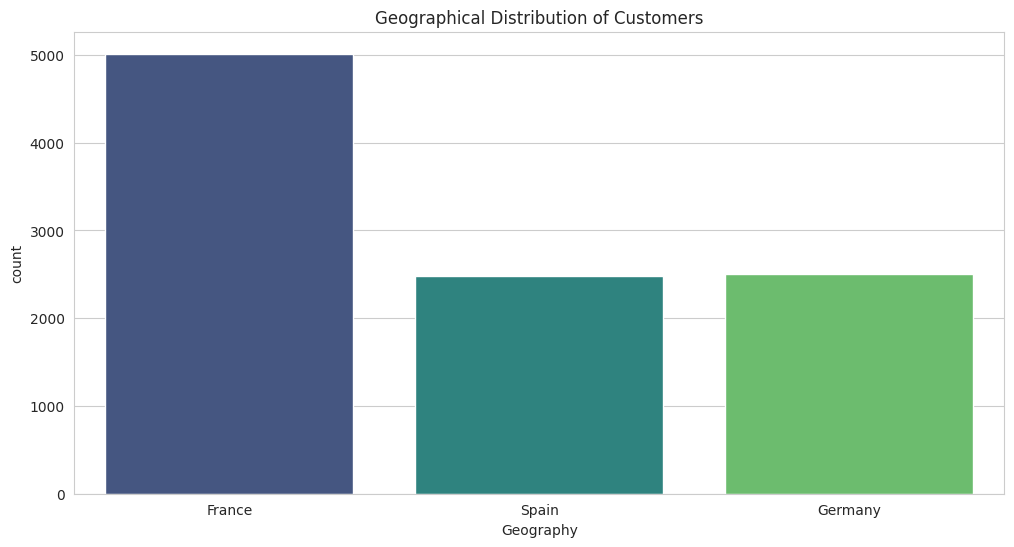

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot countplot on the single subplot
sns.countplot(x='Geography', data=data, ax=ax, palette='viridis')
ax.set_title('Geographical Distribution of Customers')

# Show the plot
plt.show()

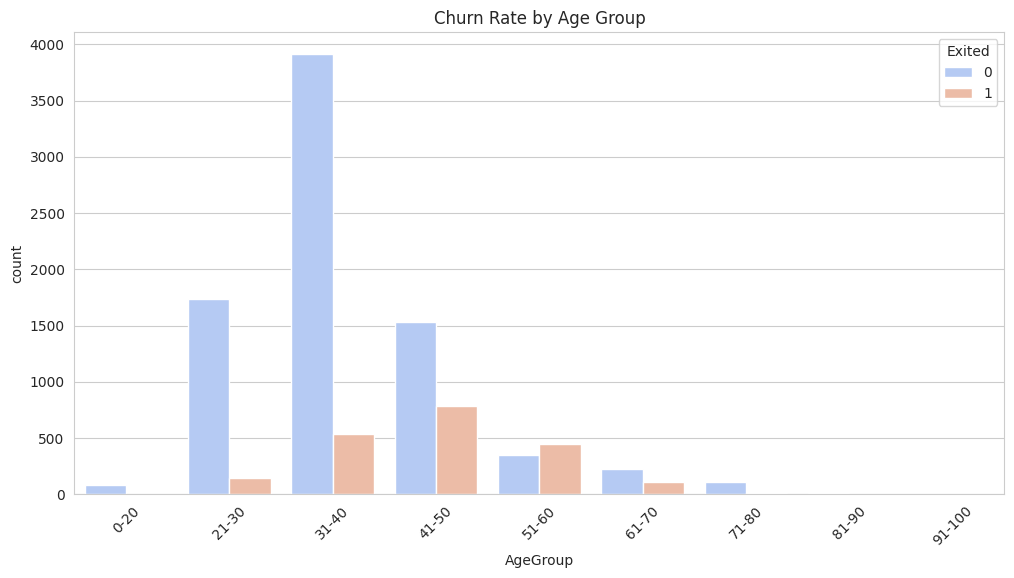

In [13]:
warnings.filterwarnings("ignore", message="The default of observed=False is deprecated", category=FutureWarning)

# Categorize 'Age' into groups for better visualization
data['AgeGroup'] = pd.cut(data['Age'], bins=[0, 20, 30, 40, 50, 60, 70, 80, 90, 100], labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'])

# Prepare figure layout for Age Group Analysis
fig, ax = plt.subplots(figsize=(12, 6))  # Changed from two subplots to one

# Plot churn rate by Age Group
sns.countplot(x='AgeGroup', hue='Exited', data=data, ax=ax, palette='coolwarm')
ax.set_title('Churn Rate by Age Group')
ax.tick_params(axis='x', rotation=45)

# Show the plot
plt.show()

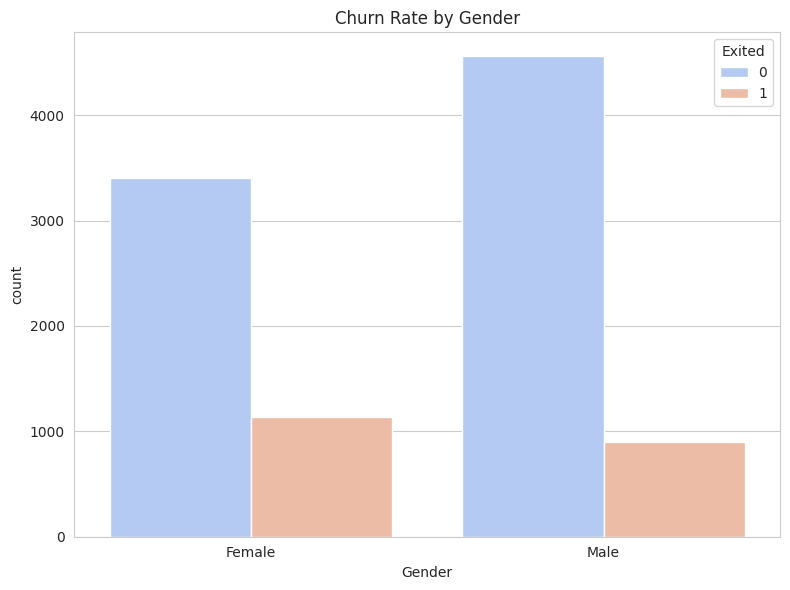

In [14]:
# Correctly setting up the figure and axes for a single plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot churn rate by Gender on the single subplot (ax)
sns.countplot(x='Gender', hue='Exited', data=data, ax=ax, palette='coolwarm')
ax.set_title('Churn Rate by Gender')

# Ensure the plot is displayed correctly
plt.tight_layout()
plt.show()

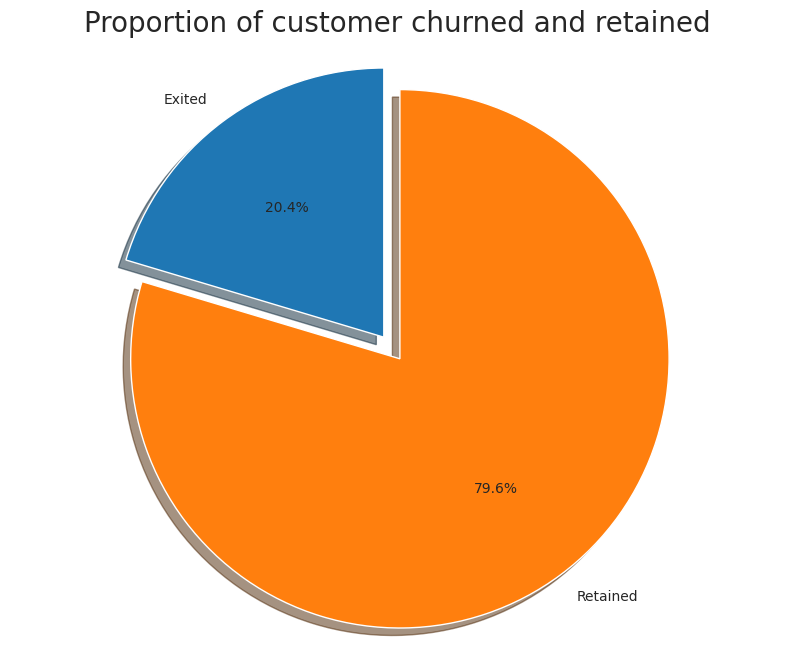

In [15]:
labels = 'Exited', 'Retained'
sizes = [data.Exited[data['Exited']==1].count(), data.Exited[data['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

**Additional Investigation of the Data**

In this part of the project we would like to explore more data. The data already separated and may return some interesting

#DS bigger

In [16]:
#the data is hardcoded (taken from Stas's computer). In case you need to download it - visit following links:
#/kaggle/input/playground-series-s4e1/train.csv
#/kaggle/input/playground-series-s4e1/test.csv
#/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv


train_data = pd.read_csv("/kaggle/input/playground-series-s4e1/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e1/test.csv")
original_data = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

<b style="font-size: 18pt;color: #CCFFE5;">
3. Creating a dataset out of the bank-customer-churn-prediction training set
</b>

**Lets take a look at the data**

In [17]:
# Training

train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [18]:
#Test

test_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [19]:
#Original

original_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [20]:
# Checking the number of rows and columns

num_train_rows, num_train_columns = train_data.shape

num_test_rows, num_test_columns = test_data.shape

num_original_rows, num_original_columns = original_data.shape

print("Training Data:")
print(f"Number of Rows: {num_train_rows}")
print(f"Number of Columns: {num_train_columns}\n")

print("Test Data:")
print(f"Number of Rows: {num_test_rows}")
print(f"Number of Columns: {num_test_columns}\n")

print("Original Data:")
print(f"Number of Rows: {num_original_rows}")
print(f"Number of Columns: {num_original_columns}")

Training Data:
Number of Rows: 165034
Number of Columns: 14

Test Data:
Number of Rows: 110023
Number of Columns: 13

Original Data:
Number of Rows: 10000
Number of Columns: 14




# We can see that this dataset propouse us training data that has almost X2 data for training than in the previous dataset (the churn_pred.csv has 10000 rows)

The next step is ... **Creating a table for missing values, unique values and data types of the features**

Exploratory Data Analysis

In [21]:
# Creating a table for missing values, unique values and data types of the features

missing_values_train = pd.DataFrame({'Feature': train_data.columns,
                              '[TRAIN] No. of Missing Values': train_data.isnull().sum().values,
                              '[TRAIN] % of Missing Values': ((train_data.isnull().sum().values)/len(train_data)*100)})

missing_values_test = pd.DataFrame({'Feature': test_data.columns,
                             '[TEST] No.of Missing Values': test_data.isnull().sum().values,
                             '[TEST] % of Missing Values': ((test_data.isnull().sum().values)/len(test_data)*100)})

missing_values_original = pd.DataFrame({'Feature': original_data.columns,
                             '[ORIGINAL] No.of Missing Values': original_data.isnull().sum().values,
                             '[ORIGINAL] % of Missing Values': ((original_data.isnull().sum().values)/len(original_data)*100)})

unique_values = pd.DataFrame({'Feature': train_data.columns,
                              'No. of Unique Values[FROM TRAIN]': train_data.nunique().values})

feature_types = pd.DataFrame({'Feature': train_data.columns,
                              'DataType': train_data.dtypes})

merged_df = pd.merge(missing_values_train, missing_values_test, on='Feature', how='left')
merged_df = pd.merge(merged_df, missing_values_original, on='Feature', how='left')
merged_df = pd.merge(merged_df, unique_values, on='Feature', how='left')
merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

merged_df

,Feature,[TRAIN] No. of Missing Values,[TRAIN] % of Missing Values,[TEST] No.of Missing Values,[TEST] % of Missing Values,[ORIGINAL] No.of Missing Values,[ORIGINAL] % of Missing Values,No. of Unique Values[FROM TRAIN],DataType
0,id,0,0.0,0.0,0.0,NaN,NaN,165034,int64
1,CustomerId,0,0.0,0.0,0.0,0.0,0.0,23221,int64
2,Surname,0,0.0,0.0,0.0,0.0,0.0,2797,object
3,CreditScore,0,0.0,0.0,0.0,0.0,0.0,457,int64
4,Geography,0,0.0,0.0,0.0,0.0,0.0,3,object
5,Gender,0,0.0,0.0,0.0,0.0,0.0,2,object
6,Age,0,0.0,0.0,0.0,0.0,0.0,71,float64
7,Tenure,0,0.0,0.0,0.0,0.0,0.0,11,int64
8,Balance,0,0.0,0.0,0.0,0.0,0.0,30075,float64
9,NumOfProducts,0,0.0,0.0,0.0,0.0,0.0,4,int64


Now, lets check the duplicates:

In [22]:
# Count duplicate rows in train_data
train_duplicates = train_data.duplicated().sum()

# Count duplicate rows in test_data
test_duplicates = test_data.duplicated().sum()

# Count duplicate rows in original_data
original_duplicates = original_data.duplicated().sum()

# Print the results
print(f"Number of duplicate rows in train_data: {train_duplicates}")
print(f"Number of duplicate rows in test_data: {test_duplicates}")
print(f"Number of duplicate rows in original_data: {original_duplicates}")

Number of duplicate rows in train_data: 0
Number of duplicate rows in test_data: 0
Number of duplicate rows in original_data: 0


In [23]:
# Having a look at the description of all the numerical columns present in the dataset

train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,165034.0,8.251650e+04,47641.356500,0.00,41258.25,82516.5,1.237748e+05,165033.00
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48


<b style="font-size: 18pt;color: #CCFFE5;">
Data Pre-Processing
</b>





**From the table above we can see that there are numerical and categorical variables. We want to split it to have the ability to wirk in more descret way. Lets separate the data to our target variable and all the other features**

In [24]:
numerical_variables = ['CreditScore','Age', 'Balance','EstimatedSalary' ]
target_variable = 'Exited'
categorical_variables = ['Geography', 'Gender', 'Tenure','NumOfProducts', 'HasCrCard','IsActiveMember']

**Numerical features investigation between the files:**

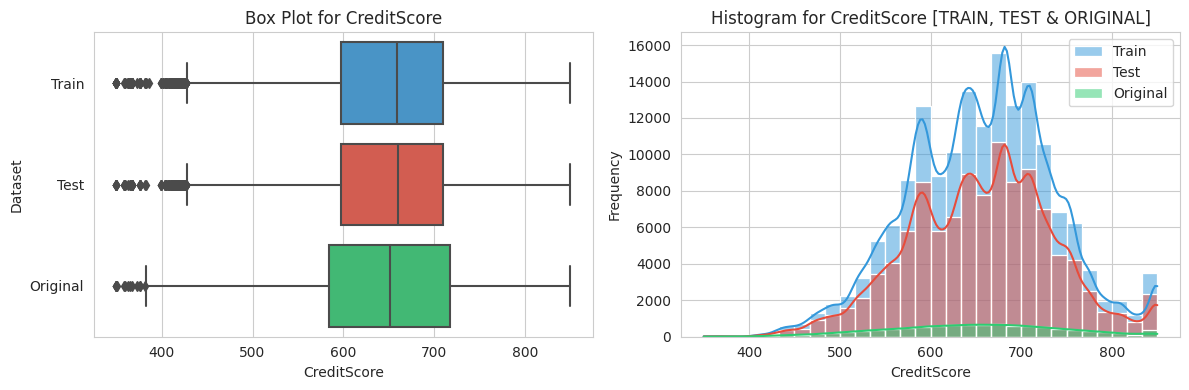

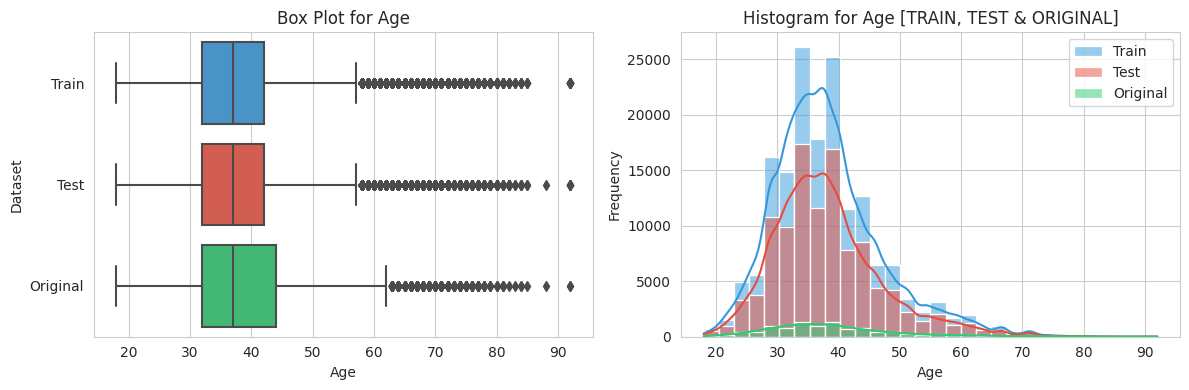

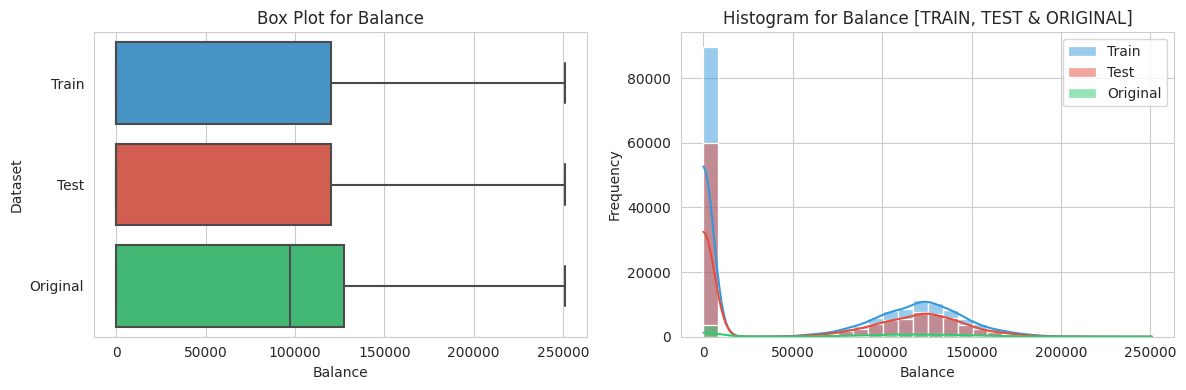

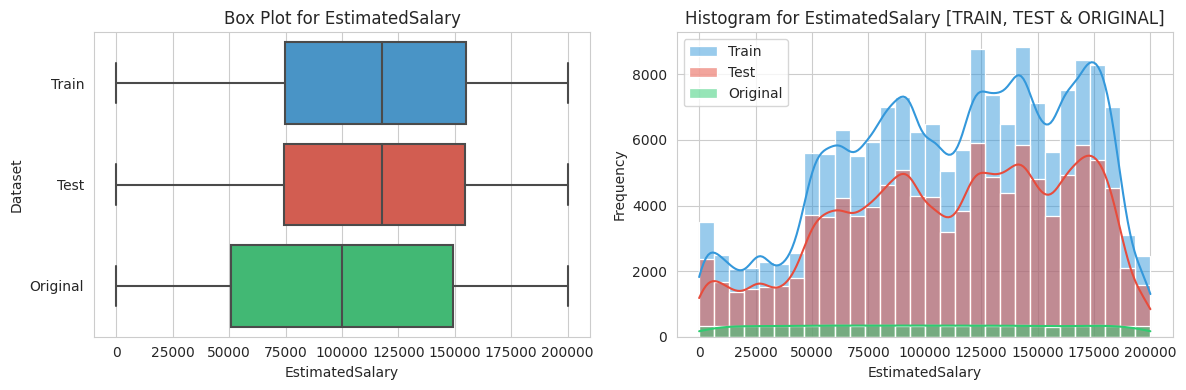

In [25]:
# Analysis of all NUMERICAL features

# Define a custom color palette
custom_palette = ['#3498db', '#e74c3c','#2ecc71']

# Add 'Dataset' column to distinguish between train and test data
train_data['Dataset'] = 'Train'
test_data['Dataset'] = 'Test'
original_data['Dataset'] = 'Original'

variables = [col for col in train_data.columns if col in numerical_variables]

# Function to create and display a row of plots for a single variable
def create_variable_plots(variable):
    sns.set_style('whitegrid')

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=pd.concat([train_data, test_data,original_data.dropna()]), x=variable, y="Dataset", palette=custom_palette)
    plt.xlabel(variable)
    plt.title(f"Box Plot for {variable}")

    # Separate Histograms
    plt.subplot(1, 2, 2)
    sns.histplot(data=train_data, x=variable, color=custom_palette[0], kde=True, bins=30, label="Train")
    sns.histplot(data=test_data, x=variable, color=custom_palette[1], kde=True, bins=30, label="Test")
    sns.histplot(data=original_data.dropna(), x=variable, color=custom_palette[2], kde=True, bins=30, label="Original")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {variable} [TRAIN, TEST & ORIGINAL]")
    plt.legend()

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Perform univariate analysis for each variable
for variable in variables:
    create_variable_plots(variable)

# Drop the 'Dataset' column after analysis
train_data.drop('Dataset', axis=1, inplace=True)
test_data.drop('Dataset', axis=1, inplace=True)
original_data.drop('Dataset', axis=1, inplace=True)

Conclusion for the Numerical Data:

CreditScore
This similarity is desirable when splitting datasets for machine learning, as it indicates that both the training and test sets may be representative of the original data, which helps in generalizing the model trained on this data.

Additionally, the histogram shows that the CreditScore variable is somewhat normally distributed in all three datasets, with the majority of CreditScores falling in the middle range and fewer at the lower and higher ends.

Age
It appears that the age distribution is roughly the same for all three datasets, which suggests that the split was done properly, maintaining the distribution of age across the subsets. The histogram peaks (mode) for all datasets are around the same age range, indicating the most common age group across the datasets. The histograms are overlaid with a kernel density estimate (KDE) curve that estimates the probability density function of the age variable.

Balance
The horizontal line inside each box represents the median of the balance distribution. The length of each box shows the interquartile range (IQR), which is the distance between the first quartile (25th percentile) and the third quartile (75th percentile). The "whiskers" extending from the boxes indicate the range of the data, typically 1.5 times the IQR above the third quartile and below the first quartile. Points outside the whiskers could be considered outliers or extreme values, which are present in the "Train" and "Test" datasets.

It appears there is a significant difference in the distribution of the "Balance" variable between the "Original" and the split datasets, which could have implications for modeling if the "Balance" is a significant predictor. This type of EDA is essential to ensure that training and test datasets are representative of the original data and to identify any preprocessing steps that might be needed.

**Categorical features investigation between the files:**

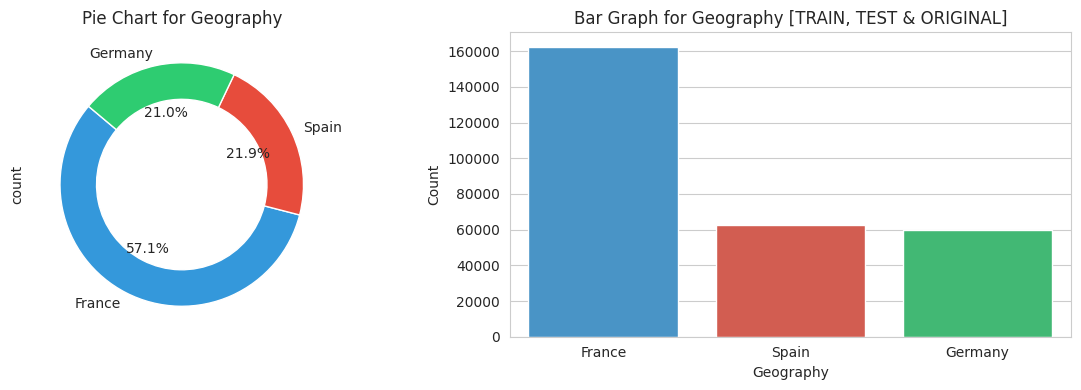

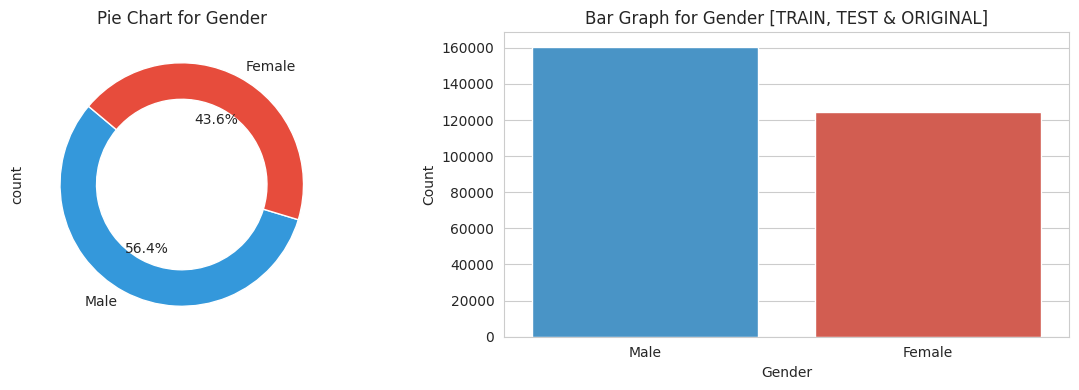

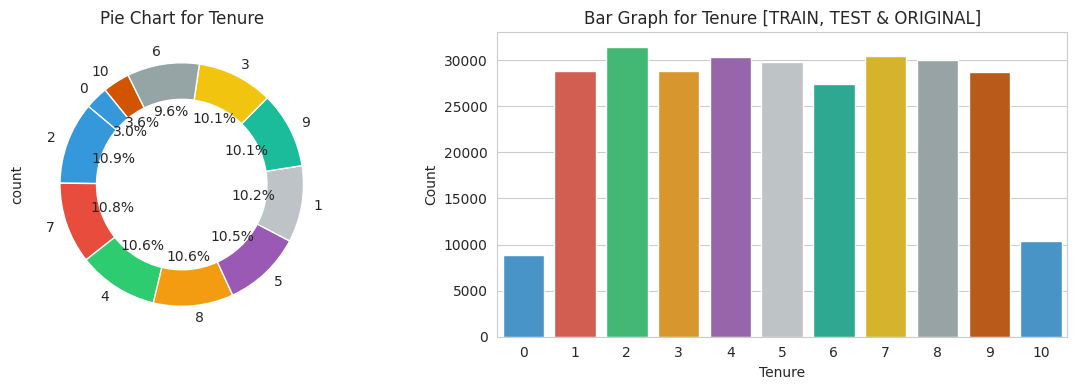

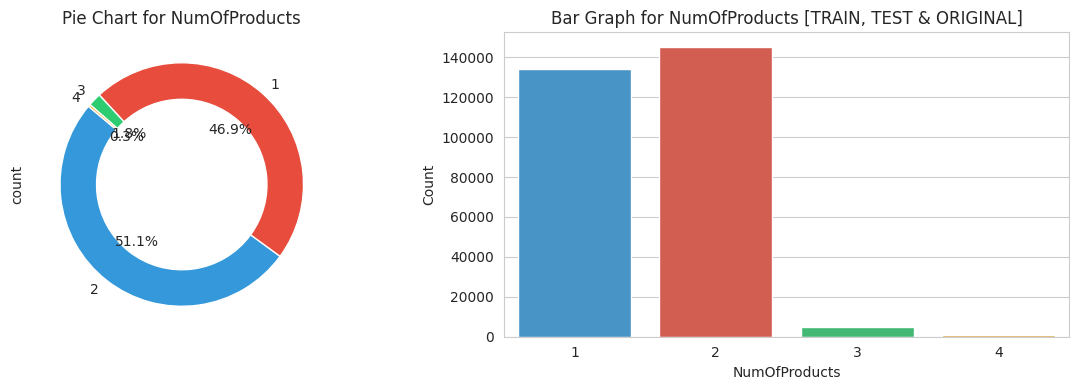

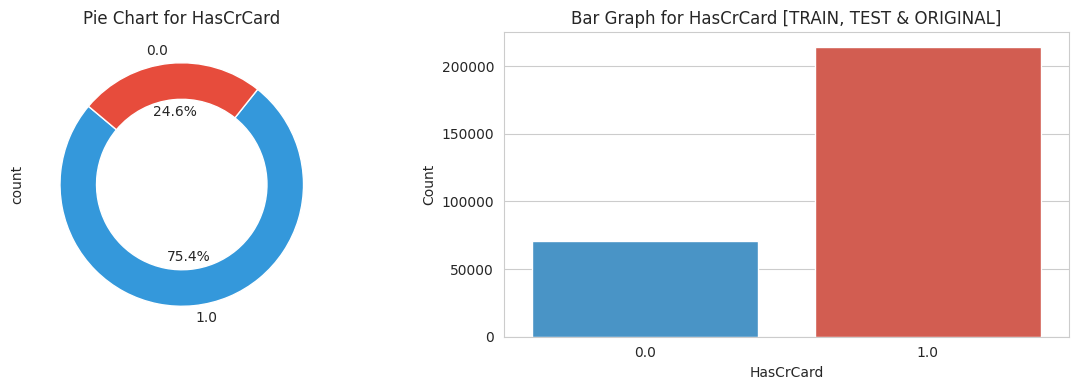

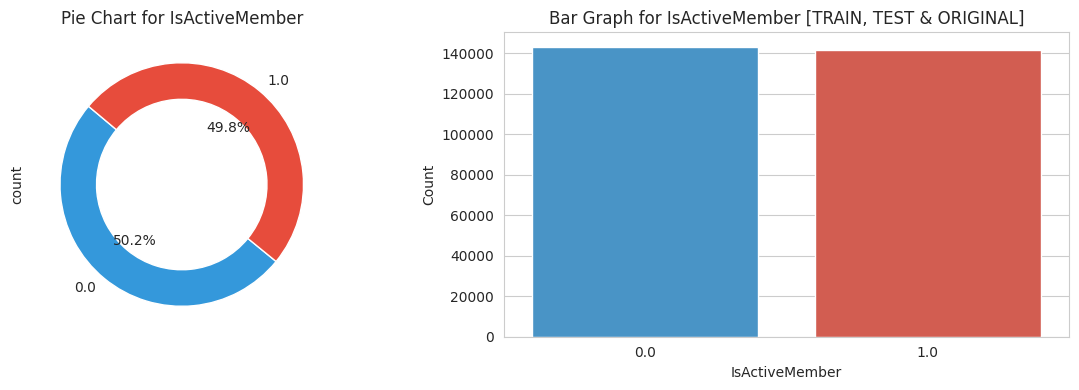

In [26]:
# Analysis of all CATEGORICAL features

# Define a custom color palette for categorical features
categorical_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#bdc3c7', '#1abc9c', '#f1c40f', '#95a5a6', '#d35400']

# List of categorical variables
categorical_variables = [col for col in categorical_variables]

# Function to create and display a row of plots for a single categorical variable
def create_categorical_plots(variable):
    sns.set_style('whitegrid')

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Pie Chart
    plt.subplot(1, 2, 1)
    train_data[variable].value_counts().plot.pie(autopct='%1.1f%%', colors=categorical_palette, wedgeprops=dict(width=0.3), startangle=140)
    plt.title(f"Pie Chart for {variable}")

    # Bar Graph
    plt.subplot(1, 2, 2)
    sns.countplot(data=pd.concat([train_data, test_data, original_data.dropna()]), x=variable, palette=categorical_palette)
    plt.xlabel(variable)
    plt.ylabel("Count")
    plt.title(f"Bar Graph for {variable} [TRAIN, TEST & ORIGINAL]")

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

# Perform univariate analysis for each categorical variable
for variable in categorical_variables:
    create_categorical_plots(variable)

**Target investigation between the files:**

#We want to see that in all the DS the target column is uniform
researchers for five percent

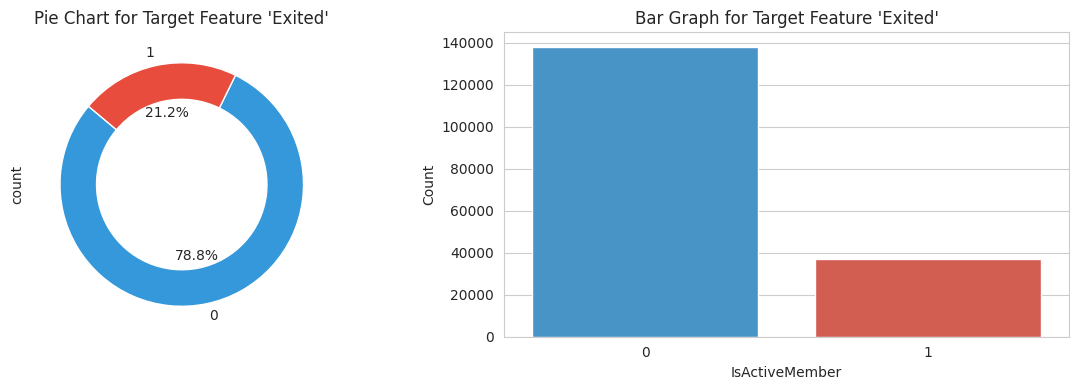

In [27]:
# Analysis of TARGET feature

# Define a custom color palette for categorical features
target_palette = ['#3498db', '#e74c3c']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie Chart
plt.subplot(1, 2, 1)
train_data[target_variable].value_counts().plot.pie(autopct='%1.1f%%', colors=target_palette, wedgeprops=dict(width=0.3), startangle=140)
plt.title(f"Pie Chart for Target Feature 'Exited'")

# Bar Graph
plt.subplot(1, 2, 2)
sns.countplot(data=pd.concat([train_data, original_data.dropna()]), x=target_variable, palette=target_palette)
plt.xlabel(variable)
plt.ylabel("Count")
plt.title(f"Bar Graph for Target Feature 'Exited'")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

***correlatiuon***



**Now for Train and Test data, lets take a look on correlatiuon.** 

**The heat map is the best representation for it:**

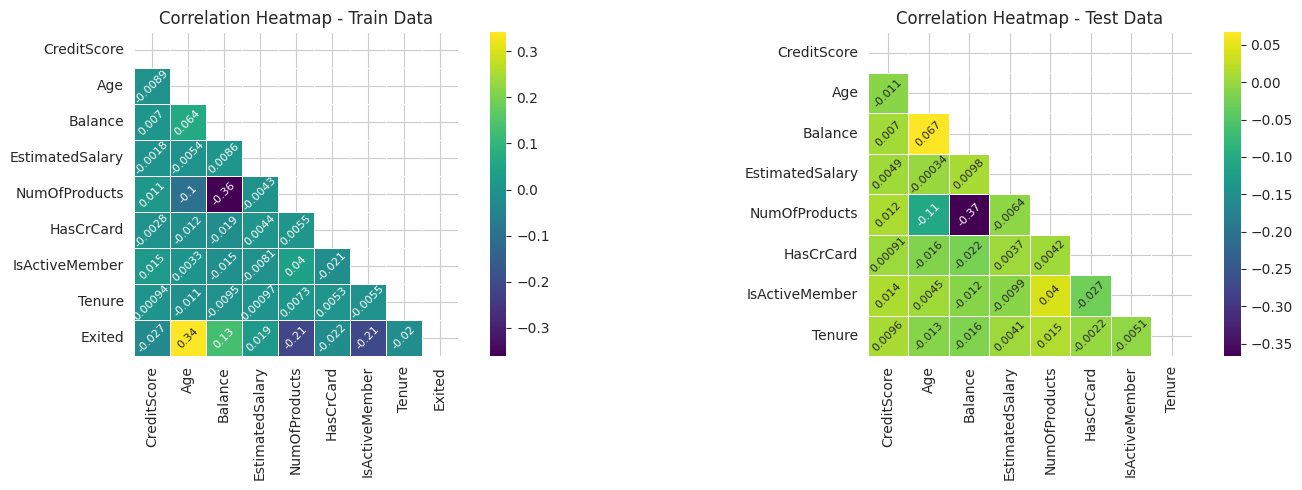

In [28]:
variables = [col for col in train_data.columns if col in numerical_variables]

cat_variables_train = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure', 'Exited']
cat_variables_test = ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure']

# Adding variables to the existing list
train_variables = variables + cat_variables_train
test_variables = variables + cat_variables_test

# Calculate correlation matrices for train_data and test_data
corr_train = train_data[train_variables].corr()
corr_test = test_data[test_variables].corr()

# Create masks for the upper triangle
mask_train = np.triu(np.ones_like(corr_train, dtype=bool))
mask_test = np.triu(np.ones_like(corr_test, dtype=bool))

# Set the text size and rotation
annot_kws = {"size": 8, "rotation": 45}

# Generate heatmaps for train_data
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
ax_train = sns.heatmap(corr_train, mask=mask_train, cmap='viridis', annot=True,
                      square=True, linewidths=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title('Correlation Heatmap - Train Data')

# Generate heatmaps for test_data
plt.subplot(1, 2, 2)
ax_test = sns.heatmap(corr_test, mask=mask_test, cmap='viridis', annot=True,
                     square=True, linewidths=.5, xticklabels=1, yticklabels=1, annot_kws=annot_kws)
plt.title('Correlation Heatmap - Test Data')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

טיפול מקדים בנתונים (Data Preprocessing) הוא שלב קריטי בתהליך כל פרויקט של ניתוח נתונים או למידת מכונה. הטיפול כולל מגוון פעולות שמטרתן להבטיח שהנתונים יהיו נקיים, מובנים ומוכנים לניתוח. כאן כמה מהסיבות העיקריות לביצוע שלב זה:

1. **שיפור איכות הנתונים:** לעיתים, הנתונים כוללים שגיאות, ערכים חסרים, או פורמטים לא אחידים שיכולים להשפיע לרעה על הניתוח. טיהור ותיקון הנתונים מבטיח שהמודל שנבנה יהיה מבוסס על מידע מדויק ואמין.

2. **המרת נתונים לפורמט ניתן לעיבוד:** יש להתאים את הנתונים לפורמט שהמודלים יכולים לעבד. לדוגמה, המרת קטגוריות טקסטואליות לערכים מספריים, נורמליזציה של טווחים מספריים, או יצירת משתנים חדשים שיכולים לסייע בניתוח.

3. **הפחתת ממדיות:** לעיתים ישנם יותר מדי משתנים בנתונים, מה שיכול להוביל לפנומנה של "ממדיות קללה" שבה המודל מתאמן יתר על המידה על הנתונים הקיימים (overfitting). הפחתת ממדיות עוזרת למנוע זאת ולשפר את יעילות המודל.

4. **איזון המערכת:** במקרים בהם יש חוסר איזון בנתונים (לדוגמה, אחוז נמוך מאוד של דוגמאות מסוימות), ייתכן שיהיה צורך לבצע טכניקות כמו דגימה מחדש לקבוצה המיעוטית או הרחבת הקבוצה הרובית.

5. **הערכת חשיבות המשתנים:** על ידי ניתוח הנתונים ובדיקת ההשפעה של כל משתנה על התוצאה, ניתן להבין אילו משתנים הם החשובים ביותר ולהתמקד בהם במהלך הניתוח.

6. **הפחתת רעשים ושגיאות:** במהלך טיפול מקדים בנתונים, ניתן לזהות ולהסיר רעשים או נתונים שאינם רלוונטיים, מה שמוביל לשיפור הדיוק של המודל.

בסופו של דבר, כל שלבי הטיפול המקדים בנתונים תורמים ליצירת מודל יותר יעיל ומדויק. זהו שלב הכרחי כדי להבטיח שהניתוח של הנתונים יהיה מוצלח ותוצאותיו תקפות.


***Data Preprocessing***



In this part of the project we'll clean the data and prepare it for the working with our model.

In [29]:
# Drop null values from original_data
original_data = original_data.dropna()
original_data.drop('RowNumber', axis=1, inplace=True)

# Print the count of null values in original_data
print(original_data.isnull().sum())

# Combine original_data with train_data
train_data = pd.concat([train_data, original_data], axis=0).reset_index(drop=True)

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64



***Feature Engineering***

One of the most important steps in Machine learning projects.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder

def tf_idf(df, column, n, p):
    # Initialize TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=n)

    # Transform data
    vectors = vectorizer.fit_transform(df[column])

    # Apply TruncatedSVD for dimensionality reduction
    svd = TruncatedSVD(p)
    x_pca = svd.fit_transform(vectors)

    # Convert to DataFrame
    tfidf_df = pd.DataFrame(x_pca)

    # Naming columns in the new DataFrame
    cols = [(column + "_tfidf_" + str(f)) for f in tfidf_df.columns.to_list()]
    tfidf_df.columns = cols

    # Reset the index of the DataFrame before concatenation
    df = df.reset_index(drop=True)

    # Concatenate transformed features with original data
    df = pd.concat([df, tfidf_df], axis="columns")

    return df

def perform_feature_engineering(df):
    # Age Group
    age_bins = [0, 18, 30, 40, 50, 60, 100]
    df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=False, right=False)

    # Balance Category
    balance_bins = [-np.inf, 0, 10000, 50000, 100000, np.inf]
    df['BalanceCategory'] = pd.cut(df['Balance'], bins=balance_bins, labels=False, right=False)

    # Credit Score Category
    credit_bins = [0, 500, 600, 700, 800, 900]
    df['CreditScoreCategory'] = pd.cut(df['CreditScore'], bins=credit_bins, labels=False, right=False)

    # Tenure Group
    tenure_bins = [0, 2, 5, 10, np.inf]
    df['TenureGroup'] = pd.cut(df['Tenure'], bins=tenure_bins, labels=False, right=False)

    # Salary to Balance Ratio
    df['SalaryToBalanceRatio'] = df['EstimatedSalary'] / (df['Balance'] + 1)  # Adding 1 to avoid division by zero

    # Credit Card and Active Member Interaction
    df['CreditCard_ActiveMember'] = df['HasCrCard'] * df['IsActiveMember']

    # Apply TF-IDF to 'Surname' column
    df = tf_idf(df, 'Surname', n=1000, p=5)

    # ABP Interaction
    df['ABPInteraction'] = df['Age'] * df['Balance'] / df['NumOfProducts']

    df['Geo_Gender'] = df['Geography'] + '_' + df['Gender']

    df['TotalProductUsage'] = df['Tenure'] * df['NumOfProducts']

    df['AgeAdjustedProductUsage'] = df['NumOfProducts']/((df['Tenure']+1) * df['Age'])

    df['Customer_Status'] = df['Tenure'].apply(lambda x: 'New' if x < 2 else 'Long-term')

    return df

# Apply the function to the training data
train_data = perform_feature_engineering(train_data)

# Apply the function to the test data
test_data = perform_feature_engineering(test_data)

**The aim of these functions is to preprocess the dataset by transforming raw data into a format that can be effectively used by machine learning algorithms, potentially enhancing model accuracy and performance by including both derived categorical data and processed text data.**

***Drop the non relevant columns***

In [31]:
columns_to_drop = ['CustomerId','Surname']
train_data.drop(columns_to_drop, axis=1, inplace=True)
test_data.drop(columns_to_drop, axis=1, inplace=True)

***Outlayer detection***

In [32]:
columns_to_check = numerical_variables

def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.1)
    Q3 = data[column].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the data
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    # Calculate the number of rows deleted
    rows_deleted = len(data) - len(filtered_data)

    return filtered_data, rows_deleted

rows_deleted_total = 0

for column in columns_to_check:
    train_data, rows_deleted = remove_outliers_iqr(train_data, column)
    rows_deleted_total += rows_deleted
    print(f"Rows deleted for {column}: {rows_deleted}")

print(f"Total rows deleted: {rows_deleted_total}")

Rows deleted for CreditScore: 0
Rows deleted for Age: 24
Rows deleted for Balance: 0
Rows deleted for EstimatedSalary: 0
Total rows deleted: 24


הקוד שהצגת עוסק בטיפול בנתונים מספריים בעזרת הסרת ערכים חריגים

1. **הגדרת רשימת עמודות לבדיקה (`columns_to_check = numerical_variables`)**:
   רשימה זו אמורה להכיל שמות של עמודות מספריות ב-DataFrame שתוך כדי הרצת הקוד יבדקו להסרת חריגים.

2. **הגדרת הפונקציה `remove_outliers_iqr`**:
   - הפונקציה מקבלת DataFrame (`data`) ושם של עמודה (`column`).
   - מחשבת את הרבעון הראשון (Q1) והרבעון התשיעי (Q3) של הנתונים בעמודה זו.
   - מחשבת את טווח הרבעונים הביניים (IQR), שהוא ההפרש בין Q3 ל-Q1.
   - מגדירה גבול תחתון ועליון עבור הערכים שנחשבים כ"תקניים". כל ערך שמחוץ לגבולות אלו נחשב כחריג.
   - יוצרת DataFrame חדש על ידי הסרת כל השורות שבהן הערכים בעמודה הנבדקת חריגים.
   - מחשבת את מספר השורות שהוסרו מהנתונים.

3. **לולאת for שבודקת כל עמודה ברשימה `columns_to_check`**:
   - עבור כל עמודה, הפונקציה מופעלת ומחזירה את ה-DataFrame ללא החריגים ואת מספר השורות שהוסרו.
   - כוללת עדכון של משתנה שמצטבר בו מספר השורות שהוסרו עבור כל עמודה.

4. **הדפסת סיכום**:
   - לאחר עיבוד כל העמודות, מודפס סיכום של מספר השורות שהוסרו לכל עמודה וכן הסכום הכולל של השורות שהוסרו מה-DataFrame.

הקוד עשוי לשפר את איכות הנתונים על ידי הסרת נתונים חריגים שעשויים להשפיע באופן שלילי על תוצאות ניתוח נתונים ולמידת מכונה.

In [33]:
y = train_data['Exited']
id_test = test_data['id']



1. **`y = train_data['Exited']`**:
   - קו זה מוציא ושומר במשתנה `y` את העמודה 'Exited' מתוך ה-DataFrame שנקרא `train_data`. 
   - עמודה זו ('Exited'), ככל הנראה, מכילה נתונים שמייצגים משתנה מטרה או תגובה (לדוגמה, אם לקוח עזב את החברה או לא). 
   - בהקשר של למידת מכונה, עמודה זו תשמש כמשתנה התגובה או הלייבל של המודל עבור הנתונים ב-`train_data`.

2. **`id_test = test_data['id']`**:
   - קו זה מוציא ושומר במשתנה `id_test` את העמודה 'id' מה-DataFrame שנקרא `test_data`.
   - עמודה זו ככל הנראה מכילה מזהים ייחודיים לכל רשומה או שורה ב-`test_data`. עמודות כאלה משמשות לעיתים קרובות כדי לזהות את הנתונים במהלך או לאחר תהליך ניתוח הנתונים, ואינן משמשות כחלק מהמודלים עצמם.
   - שימוש טיפוסי במזהים כאלו הוא לצורך שיוך תוצאות המודל לנתונים המתאימים, במיוחד במקרים שבהם נדרש להגיש תוצאות ניבוי למערכת חיצונית או להגיש תוצאות תחרות.
.

***Transformation of Distributions***

#Find strong feature

In [34]:
# [FOR TRAIN]
# Identify features with skewness greater than 0.75
# Get the index of the data to be transformed
skewed_features = train_data[numerical_variables].skew()[train_data[numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Apply log1p transformation to skewed features
train_data[skewed_features] = np.log1p(train_data[skewed_features])

Features to be transformed (skewness > 0.75):


array(['Age'], dtype=object)

עיבוד וטרנספורמציה של נתונים מספריים בסט האימונים

1. **איתור תכונות עם שיוויון משוחד (skewness):**
   - הקוד מבצע חישוב של מדד השיוויון (skewness) לכל התכונות המספריות ב-DataFrame (`train_data`), כאשר רק עמודות שמצויות ברשימה `numerical_variables` נלקחות בחשבון.
   - שיוויון משוחד מודד כמה התפלגות הנתונים מוטה מההתפלגות הנורמלית (גאוסית). ערכים גבוהים מ-0.75 מציינים שיוויון משוחד חיובי במיוחד, שבו הזנב של ההתפלגות נמצא מצד ימין.
   - המשתנה `skewed_features` מכיל את אינדקסים של התכונות המספריות עם שיוויון משוחד גבוה מ-0.75.

2. **הדפסת רשימת התכונות לטרנספורמציה:**
   - מדפיס את רשימת התכונות שדורשות טרנספורמציה עקב שיוויון משוחד גבוה.

3. **יישום טרנספורמציה של לוגריתם טבעי (log1p) על התכונות המשוחדות:**
   - פונקציית ה`np.log1p` מבצעת טרנספורמציה של לוגריתם טבעי שכוללת הוספה של 1 לערך (כלומר, חישוב של `log(1 + x)`). היא מתאימה במיוחד לערכים של נתונים הכוללים אפסים, מאחר ש`log(0)` אינו מוגדר.
   - הטרנספורמציה הזו משמשת להפחתת השיוויון המשוחד ולהקטנת ההשפעה של ערכים גבוהים במיוחד, מה שעשוי לשפר את ביצועי מודלי הלמידה.

באופן כללי, השלבים אלו מיועדים להכנת הנתונים לניתוח סטטיסטי ולמידת מכונה על ידי יצירת תכונות חדשות שהן פחות מוטות ויותר קרובות להתפלגות נורמלית.


הטיפול בשיוויון משוחד (skewness) של נתונים נעשה מכמה סיבות עיקריות, כשהמטרה היא לשפר את יעילות ואמינות הניתוחים הסטטיסטיים ולמידת המכונה:

1. **השגת נורמליות בהתפלגות:** רוב המודלים הסטטיסטיים ואלגוריתמים מניחים, במידה רבה או פחותה, שהנתונים מתפלגים נורמלית (גאוסית). כאשר נתונים מוטים מאוד (משוחדים), הם עלולים להשפיע שלילית על הדיוק של האומדנים ותוצאות הניתוח.

2. **שיפור אומדני פרמטרים ותחזיות:** נתונים עם שיוויון משוחד יכולים לגרום לבעיות בתהליך הלמידה של המודלים, כולל אומדנים מוטים וחוסר יציבות. טרנספורמציות לוגריתמיות יכולות להפחית את השפעות אלו ולעזור להגיע לתחזיות מדויקות יותר.

3. **התמודדות עם ערכים קיצוניים:** נתונים עם שיוויון משוחד גבוה מכילים לעיתים קרובות ערכים קיצוניים (outliers) שיכולים לשבש את תוצאות המודל. הטרנספורמציה עשויה למתן את ההשפעה של ערכים אלו.

4. **שיפור תוצאות למודלים שמבוססים על הנחות על התפלגות:** דוגמאות כוללות רגרסיה לינארית, אנליזה של שונות (ANOVA), ומודלים אחרים שמניחים נורמליות או שוויון של וריאנסים. הטרנספורמציה מסייעת לעמוד בדרישות אלו ולשפר את הביצועים.

במהלך עבודה עם נתונים ממשיתים, יש לבדוק את השפעת הטרנספורמציה על הדיוק והאמינות של המודלים. לפעמים ייתכן שיהיה צורך לנסות מספר טרנספורמציות שונות (כמו שורש ריבועי, הופכית, ועוד) כדי למצוא את המתאימה ביותר לנתונים ולמודל שנבחר.

In [35]:
# [FOR TEST]
# Identify features with skewness greater than 0.75
# Get the index of the data to be transformed
skewed_features = test_data[numerical_variables].skew()[test_data[numerical_variables].skew() > 0.75].index.values

# Print the list of variables to be transformed
print("Features to be transformed (skewness > 0.75):")
display(skewed_features)

# Apply log1p transformation to skewed features
test_data[skewed_features] = np.log1p(test_data[skewed_features])

Features to be transformed (skewness > 0.75):


array(['Age'], dtype=object)

הקוד שהצגת עושה בדיוק את אותה פעולה שתוארה קודם לכן עבור הסט של נתוני האימון (`train_data`), אך הפעם עבור נתוני הבדיקה (`test_data`). זהו תהליך חשוב בטיפול בנתונים כדי להבטיח עקביות בין סט האימון וסט הבדיקה:

1. **איתור תכונות עם שיוויון משוחד (skewness) גדול מ-0.75 בנתוני הבדיקה:**
   - הקוד מחשב את מדד השיוויון לכל התכונות המספריות ב-`test_data` המצויות ברשימה `numerical_variables`.
   - הוא אוסף את אינדקסים של התכונות שיש להן שיוויון משוחד גבוה מ-0.75 לתוך המשתנה `skewed_features`.

2. **הדפסת רשימת התכונות שצריכות טרנספורמציה:**
   - מדפיס את רשימת התכונות שזוהו כמשוחדות ודורשות טרנספורמציה.

3. **יישום טרנספורמציה של לוגריתם טבעי (log1p) על התכונות המשוחדות בנתוני הבדיקה:**
   - עושה שימוש בפונקציה `np.log1p` שמבצעת טרנספורמציה של לוגריתם טבעי (כלומר, `log(1 + x)`) על כל התכונות שזוהו כמשוחדות.
   - זו פונקציה שמיועדת להפחית שיוויון משוחד ולטפל בערכים קיצוניים ומוטים בנתונים.

**חשיבות העקביות בין סטי הנתונים:**
השימוש באותה טרנספורמציה על שני סטי הנתונים (אימון ובדיקה) מבטיח ששני הסטים יהיו דומים ככל הניתן בהיבטים סטטיסטיים ובתכונות הנלמדות. זה מונע את הבעיה של דיווח (overfitting) ומבטיח שהמודל יוכל להיות מיושם באופן יעיל על נתונים חדשים.

**Feature encoding**


This process is crucial because most algorithms can only interpret numerical values, and real-world data often comes in various formats such as text, images, or categorical data. Encoding transforms these non-numeric formats into numerical formats, enabling algorithms to process and learn from the data. Without proper feature encoding, a machine learning model might struggle to understand the input data, leading to suboptimal or inaccurate predictions.

In [36]:
# Selecting specific columns for encoding
columns_to_encode = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember','Geo_Gender','Customer_Status']
train_data_to_encode = train_data[columns_to_encode]
test_data_to_encode = test_data[columns_to_encode]

# Dropping selected columns for scaling
train_data_to_scale = train_data.drop(columns_to_encode, axis=1)
test_data_to_scale = test_data.drop(columns_to_encode, axis=1)

בחירת עמודות לקידוד והסרת עמודות מסוימות לצורך נרמול או סקיילינג

1. **בחירת עמודות לקידוד (Encoding):**
   - הקוד יוצר רשימה בשם `columns_to_encode` המכילה את שמות העמודות שצריכות לעבור קידוד. עמודות אלו כוללות תכונות קטגוריות (`Geography`, `Gender`) ותכונות בינאריות או דיסקרטיות (`NumOfProducts`, `HasCrCard`, `IsActiveMember` וכו').
   - לאחר מכן, הקוד מבצע בחירה של העמודות הללו מתוך `train_data` ו`test_data` ושומר אותן ב-DataFrames חדשים בשמות `train_data_to_encode` ו`test_data_to_encode`. נתונים אלו ישמשו בהמשך לקידוד, לדוגמה באמצעות קידוד חם אחד (One-Hot Encoding) או קידוד מספרי.

2. **הסרת עמודות שנבחרו לקידוד מה-DataFrames לצורך נרמול/סקיילינג:**
   - הקוד מסיר את העמודות שברשימת `columns_to_encode` מה-DataFrames המקוריים של `train_data` ו`test_data`. הוא עושה זאת באמצעות שימוש בפונקציה `drop` עם הפרמטר `axis=1` (שמציין הסרה של עמודות ולא שורות).
   - ה-DataFrames שנוצרים לאחר ההסרה, `train_data_to_scale` ו`test_data_to_scale`, יכילו רק את העמודות שלא דורשות קידוד וייתכן שיש להם צורך בטיפולים נוספים כמו נרמול או סקיילינג לפני שימוש במודל למידת מכונה.


שני סוגי עיבוד נתונים: הכנת נתונים קטגוריים ובינאריים לקידוד, והכנת נתונים נומריים או תכונות קטגוריות שנשארות לסקיילינג או נרמול. שתי הפעולות חשובות להבטחת שהמודל יקבל נתונים בצורה אופטימלית, מה שיכול להשפיע במידה רבה על דיוק התחזיות והביצועים שלו.

In [37]:
# Use pandas get_dummies to one-hot encode 'Geography' and 'Gender' in train_data
train_data_encoded = pd.get_dummies(train_data_to_encode, columns=['Geography', 'Gender','NumOfProducts', 'HasCrCard','IsActiveMember','Geo_Gender','Customer_Status'], drop_first=True)

# Use pandas get_dummies to one-hot encode 'Geography' and 'Gender' in test_data
test_data_encoded = pd.get_dummies(test_data_to_encode, columns=['Geography', 'Gender','NumOfProducts', 'HasCrCard','IsActiveMember','Geo_Gender','Customer_Status'], drop_first=True)

In [38]:
train_data_encoded.head()

,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1.0,IsActiveMember_1.0,Geo_Gender_France_Male,Geo_Gender_Germany_Female,Geo_Gender_Germany_Male,Geo_Gender_Spain_Female,Geo_Gender_Spain_Male,Customer_Status_New
0,False,False,True,True,False,False,True,False,True,False,False,False,False,False
1,False,False,True,True,False,False,True,True,True,False,False,False,False,True
2,False,False,True,True,False,False,True,False,True,False,False,False,False,False
3,False,False,True,False,False,False,True,True,True,False,False,False,False,False
4,False,True,True,True,False,False,True,True,False,False,False,False,True,False



### למה זה שימושי?
- **תצוגה מקדימה של הנתונים**: זה מאפשר לך לבדוק במהירות אילו עמודות נוצרו בעקבות הקידוד, איך הערכים המקוריים הומרו לערכים בינאריים, ולוודא שהתהליך התבצע כשורה.
- **אימות הנתונים**: זה מאפשר לאשר שהנתונים נראים כפי שציפית להם לאחר העיבוד, ושאין בעיות ברורות כגון עמודות חסרות או ערכים לא צפויים.
- **בדיקה וניתוח מהירים**: מספקת דרך נוחה ומהירה לקבל הצצה ראשונית למבנה הנתונים לפני עיבוד נוסף או ניתוח עמוק יותר.

בעקבות הפקודה הזו, תוכל לראות אילו עמודות נוספו, כמה עמודות נוצרו לכל קטגוריה, ואיך המידע מוצג ב-DataFrame החדש.

In [39]:
test_data_encoded.head()

,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1.0,IsActiveMember_1.0,Geo_Gender_France_Male,Geo_Gender_Germany_Female,Geo_Gender_Germany_Male,Geo_Gender_Spain_Female,Geo_Gender_Spain_Male,Customer_Status_New
0,False,False,False,True,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,False,False,False,False
2,False,False,False,True,False,False,True,False,False,False,False,False,False,False
3,False,False,True,False,False,False,True,False,True,False,False,False,False,False
4,True,False,True,False,False,False,True,False,False,False,True,False,False,False


At the end we see that we brought our data to the same type of representation.

***Feature scaling***

In [40]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on the training data
minmax_scaler.fit(train_data_to_scale.drop(['Exited'], axis=1))

# Scale the training data
scaled_data_train = minmax_scaler.transform(train_data_to_scale.drop(['Exited'], axis=1))
scaled_train_df = pd.DataFrame(scaled_data_train, columns=train_data_to_scale.drop(['Exited'], axis=1).columns)

# Scale the test data using the parameters from the training data
scaled_data_test = minmax_scaler.transform(test_data_to_scale)
scaled_test_df = pd.DataFrame(scaled_data_test, columns=test_data_to_scale.columns)

In [41]:
scaled_train_df.head()

,id,CreditScore,Age,Tenure,Balance,EstimatedSalary,AgeGroup,BalanceCategory,CreditScoreCategory,TenureGroup,SalaryToBalanceRatio,CreditCard_ActiveMember,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,ABPInteraction,TotalProductUsage,AgeAdjustedProductUsage
0,0.000000,0.636,0.391503,0.3,0.000000,0.907279,0.25,0.0,0.50,0.333333,0.907284,0.0,0.001762,0.004781,0.489942,0.007446,0.340182,0.000000,0.15,0.094060
1,0.000006,0.554,0.391503,0.1,0.000000,0.247483,0.25,0.0,0.50,0.000000,0.247527,1.0,0.001762,0.004781,0.489938,0.007453,0.340190,0.000000,0.05,0.195851
2,0.000012,0.656,0.517455,1.0,0.000000,0.924364,0.50,0.0,0.50,1.000000,0.924368,0.0,0.002049,0.001119,0.490526,0.000000,0.328438,0.000000,0.50,0.022806
3,0.000018,0.462,0.411005,0.2,0.593398,0.422787,0.25,1.0,0.25,0.333333,0.000003,1.0,0.001708,0.006457,0.489180,0.013751,0.350857,0.358157,0.05,0.058134
4,0.000024,0.732,0.391503,0.5,0.000000,0.075293,0.25,0.0,0.75,0.666667,0.075347,1.0,0.001762,0.004782,0.489940,0.007447,0.340182,0.000000,0.25,0.060130


In [42]:
scaled_test_df.head()

,id,CreditScore,Age,Tenure,Balance,EstimatedSalary,AgeGroup,BalanceCategory,CreditScoreCategory,TenureGroup,SalaryToBalanceRatio,CreditCard_ActiveMember,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,ABPInteraction,TotalProductUsage,AgeAdjustedProductUsage
0,1.000006,0.472,0.157171,0.2,0.000000,0.804903,0.00,0.0,0.25,0.333333,0.804914,0.0,0.001785,0.004793,0.489861,0.007230,0.340673,0.000000,0.10,0.187000
1,1.000012,0.666,0.609339,0.2,0.000000,0.362723,0.50,0.0,0.50,0.333333,0.362760,0.0,0.001762,0.004781,0.489940,0.007447,0.340185,0.000000,0.05,0.040952
2,1.000018,0.612,0.411005,0.7,0.000000,0.694419,0.25,0.0,0.50,0.666667,0.694437,0.0,0.001762,0.004781,0.489940,0.007447,0.340185,0.000000,0.35,0.041668
3,1.000024,0.662,0.448391,0.8,0.000000,0.569654,0.25,0.0,0.50,0.666667,0.569679,0.0,0.001768,0.004794,0.489930,0.007371,0.340205,0.000000,0.20,0.013004
4,1.000030,0.804,0.483809,1.0,0.483318,0.697164,0.25,1.0,0.75,1.000000,0.000006,0.0,0.001762,0.004781,0.489940,0.007447,0.340185,0.326036,0.25,0.008341


**This procedure ensures that both training and test datasets are scaled in the same manner, which is crucial for the fair evaluation of machine learning models, as they depend on consistent data inputs across different datasets.**

הליך זה מבטיח כי הן מערכי הנתונים של הדרכה והן מערכי נתונים של בדיקות מגודלים באותו אופן, דבר חיוני להערכה הוגנת של מודלים של למידת מכונה, מכיוון שהם תלויים בקלט נתונים עקבי על פני מערכי נתונים שונים.

***Lets combine back our data:***

In [43]:
# Concatenate train datasets
train_data_combined = pd.concat([train_data_encoded.reset_index(drop=True), scaled_train_df.reset_index(drop=True)], axis=1)

# Concatenate test datasets
test_data_combined = pd.concat([test_data_encoded.reset_index(drop=True), scaled_test_df.reset_index(drop=True)], axis=1)

In [44]:
train_data_combined.head()

,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1.0,IsActiveMember_1.0,Geo_Gender_France_Male,Geo_Gender_Germany_Female,...,SalaryToBalanceRatio,CreditCard_ActiveMember,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,ABPInteraction,TotalProductUsage,AgeAdjustedProductUsage
0,False,False,True,True,False,False,True,False,True,False,...,0.907284,0.0,0.001762,0.004781,0.489942,0.007446,0.340182,0.000000,0.15,0.094060
1,False,False,True,True,False,False,True,True,True,False,...,0.247527,1.0,0.001762,0.004781,0.489938,0.007453,0.340190,0.000000,0.05,0.195851
2,False,False,True,True,False,False,True,False,True,False,...,0.924368,0.0,0.002049,0.001119,0.490526,0.000000,0.328438,0.000000,0.50,0.022806
3,False,False,True,False,False,False,True,True,True,False,...,0.000003,1.0,0.001708,0.006457,0.489180,0.013751,0.350857,0.358157,0.05,0.058134
4,False,True,True,True,False,False,True,True,False,False,...,0.075347,1.0,0.001762,0.004782,0.489940,0.007447,0.340182,0.000000,0.25,0.060130


In [45]:
test_data_combined.head()

,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1.0,IsActiveMember_1.0,Geo_Gender_France_Male,Geo_Gender_Germany_Female,...,SalaryToBalanceRatio,CreditCard_ActiveMember,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4,ABPInteraction,TotalProductUsage,AgeAdjustedProductUsage
0,False,False,False,True,False,False,False,True,False,False,...,0.804914,0.0,0.001785,0.004793,0.489861,0.007230,0.340673,0.000000,0.10,0.187000
1,False,False,False,False,False,False,True,False,False,False,...,0.362760,0.0,0.001762,0.004781,0.489940,0.007447,0.340185,0.000000,0.05,0.040952
2,False,False,False,True,False,False,True,False,False,False,...,0.694437,0.0,0.001762,0.004781,0.489940,0.007447,0.340185,0.000000,0.35,0.041668
3,False,False,True,False,False,False,True,False,True,False,...,0.569679,0.0,0.001768,0.004794,0.489930,0.007371,0.340205,0.000000,0.20,0.013004
4,True,False,True,False,False,False,True,False,False,False,...,0.000006,0.0,0.001762,0.004781,0.489940,0.007447,0.340185,0.326036,0.25,0.008341


***Dropping Highly Correlated Features***

Additional step in feature engineering

השמטת תכונות בעלות מתאם גבוה שלב נוסף בהנדסת תכונות

In [46]:
submit = False

In [47]:
# Add the 'Exited' column back to the scaled training data
train_data_combined['Exited'] = train_data['Exited'].values

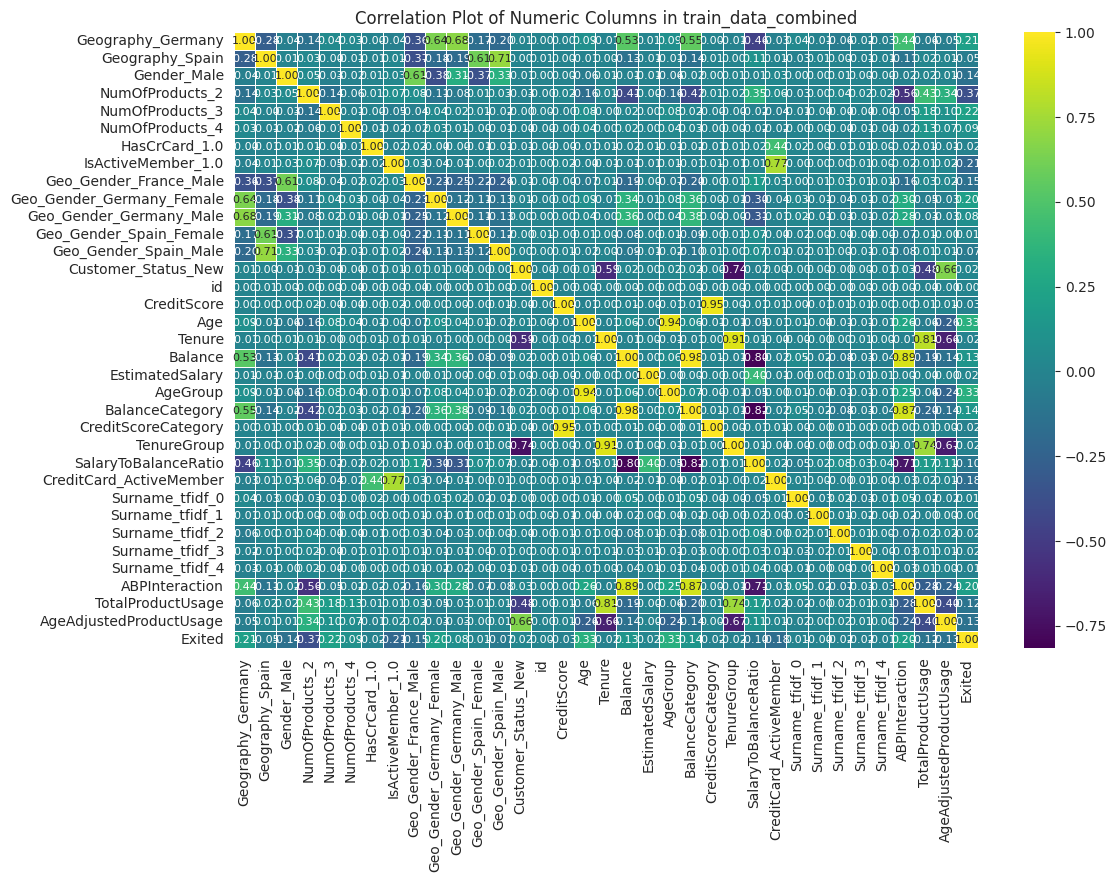

In [48]:
# Select numeric columns
numeric_cols = train_data_combined.select_dtypes(include=['number', 'bool'])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

# Create a heatmap using Seaborn with smaller font size for annotations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Plot of Numeric Columns in train_data_combined')
plt.show()

Analyze data

### 1. בחירת עמודות נומריות:
- **`numeric_cols = train_data_combined.select_dtypes(include=['number', 'bool'])`**: בשורה זו מתבצעת בחירה של כל העמודות ב-DataFrame `train_data_combined` שהן מסוג נומרי או בוליאני. פונקציה זו מועילה לפילוח עמודות בסיס על סוג הנתונים, כדי להכין אותן לניתוחים נוספים.

### 2. חישוב מטריצת הקורלציה:
- **`corr_matrix = numeric_cols.corr()`**: מחשבת את מטריצת הקורלציה בין כל העמודות הנומריות והבוליאניות ב-DataFrame. קורלציה מודדת את הקשר הליניארי בין זוגות משתנים, כאשר הערכים נעים בין -1 ל-1.

### 3. יצירת מפת חום (Heatmap) בעזרת Seaborn:
- **`plt.figure(figsize=(12, 8))`**: קודם כל, מגדירים את גודל הפיגורה להצגה על מנת להבטיח שהתרשים יהיה ברור וקריא.
- **`sns.heatmap(...)`**: פונקציה זו מ- seaborn מציירת מפת חום שמייצגת את מטריצת הקורלציה. האופציות שמועברות לפונקציה כוללות:
  - **`annot=True`**: מציין שערכי הקורלציה יוצגו על התרשים.
  - **`cmap='viridis'`**: מציין את פלטת הצבעים לשימוש במפת החום.
  - **`fmt='.2f'`**: פורמט ההצגה של המספרים על המפה, כאן לשני מקומות עשרוניים.
  - **`linewidths=0.5`**: עובי הקווים המפרידים בין התאים במפת החום.
  - **`annot_kws={"size": 8}`**: מגדיר את גודל הטקסט באנוטציות להיות קטן (8 נקודות), מה שמתאים יותר למפה עם הרבה ערכים.
- **`plt.title('Correlation Plot of Numeric Columns in train_data_combined')`**: מוסיף כותרת לתרשים.
- **`plt.show()`**: מציג את הפיגורה שנוצרה.

 חשיבות הפעולה:
ההצגה גרפית של מטריצת הקורלציה מאפשרת לחקור את הקשרים בין המשתנים השונים בנתונים. מפת חום זו יכולה לעזור לזהות משתנים שיש להם קורלציה גבוהה זה עם זה, מה שיכול להשפיע על ביצועי מודלים סטטיסטיים ולסייע בזיהוי של מולטיקולינריות אפשרית בנתונים.

<b style="font-size: 18pt;color: #CCFFE5;">
5.Creating the Models
</b>

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

X = train_data_combined.drop('Exited',axis=1)
y = train_data_combined['Exited']

# Function to display feature importance
def display_feature_importance(model, top_n=34,percentage=3, plot=False):

    # Adjusting parameters based on the model type
    fit_params= {}
    if isinstance(model, lgb.LGBMClassifier):
      model = lgb.LGBMClassifier(verbose=-1)  # Set verbosity at model creation
    elif isinstance(model, XGBClassifier) or isinstance(model, CatBoostClassifier):
      fit_params = {"verbose": 0}

    # Fit the model
    model.fit(X, y, **fit_params)

    # Get feature importance
    feature_importance = model.feature_importances_
    feature_names = X.columns

    # Create a DataFrame for better visualization
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Sort features by importance
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Calculate threshold based on percentage of the top feature importance
    threshold = percentage / 100 * feature_importance_df.iloc[0]['Importance']

    # Select features that meet the threshold
    selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()

    if plot==True:
        # Set seaborn color palette to "viridis"
        sns.set(style="whitegrid", palette="viridis")

        # Display or plot the top features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
        plt.title('Feature Importance for {}'.format(type(model).__name__))
        plt.show()

        print("Selected Features at threshold {}%; {}".format(percentage,selected_features))

    # Add 'Exited' to the list of selected features
    selected_features.append('Exited')

    return selected_features



### פרטי הקוד:
1. **הגדרת נתונים והכנתם למידה:**
   - `X` מכיל את כל העמודות מ-`train_data_combined` למעט 'Exited', שהיא המשתנה המוסבר (target variable).
   - `y` מכיל את ערכי העמודה 'Exited', אשר משמשת כמשתנה תגובה.

2. **הגדרת פונקציה `display_feature_importance`:**
   - **פרמטרים:**
     - `model`: מודל למידת מכונה שיש לחקור.
     - `top_n=34`: מספר התכונות העליונות להצגה.
     - `percentage=3`: אחוז חשיבות לסינון תכונות.
     - `plot=False`: האם לצייר גרף של חשיבות התכונות.

   - **התאמות לפי סוג המודל:**
     - מתאים פרמטרים מיוחדים לכל מודל, לדוגמה שקט במהלך הריצה (`verbose=0` או `verbose=-1`) עבור מודלים מסוימים.

   - **אימון המודל וחישוב חשיבות התכונות:**
     - מתאים את המודל על הנתונים.
     - מחשב את חשיבות התכונות (`feature_importances_`).
     - יוצר DataFrame עם שמות התכונות וחשיבותן.

   - **סינון תכונות על פי אחוז חשיבות:**
     - מחשב את ערך הסף לחשיבות תכונה מהערך המקסימלי כפול אחוז מסוים.
     - בוחר רק תכונות שחשיבותן גבוהה מהסף.

   - **הצגת חשיבות התכונות גרפית (אם נדרש):**
     - משתמש ב-Seaborn ליצירת גרף ברים שמייצג את חשיבות התכונות.
     - מציין אילו תכונות נבחרו על פי הסף.

3. **החזרת רשימת התכונות הנבחרות:**
   - הוספת העמודה 'Exited' בחזרה לרשימת התכונות הנבחרות כדי שתהיה זמינה לשימושים נוספים או ניתוחים.

הפונקציה מאפשרת לחקור את חשיבות התכונות בקנה מידה רחב יותר, להבין אילו מהן משפיעות יותר על התוצאות ולסנן תכונות שאינן משפיעות מספיק, כל זאת באופן שיטתי ואוטומטי. זה מסייע לשפר את אפקטיביות ויעילות מודלי למידת מכונה על ידי מיקוד בתכונות הרלוונטיות ביותר.

Plotting Feature Importance for different % thresholds of acceptable Importance Values

התוויית תכונות חשיבות עבור ערכי סף % שונים של ערכי חשיבות מקובלים

In [50]:
!pip install catboost

In [51]:
!pip install --upgrade lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 15.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.2.0
    Uninstalling lightgbm-4.2.0:
      Successfully uninstalled lightgbm-4.2.0


[LightGBM] [Info] Number of positive: 25863, number of negative: 96644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3141
[LightGBM] [Info] Number of data points in the train set: 122507, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211114 -> initscore=-1.318221
[LightGBM] [Info] Start training from score -1.318221
[LightGBM] [Info] Number of positive: 25863, number of negative: 96644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3117
[LightGBM] [Info] Number of data points in the train set: 122507, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211114 -> initscore=-1.318221
[LightGBM] [Info] Start training from score -1.318221
[LightGBM]

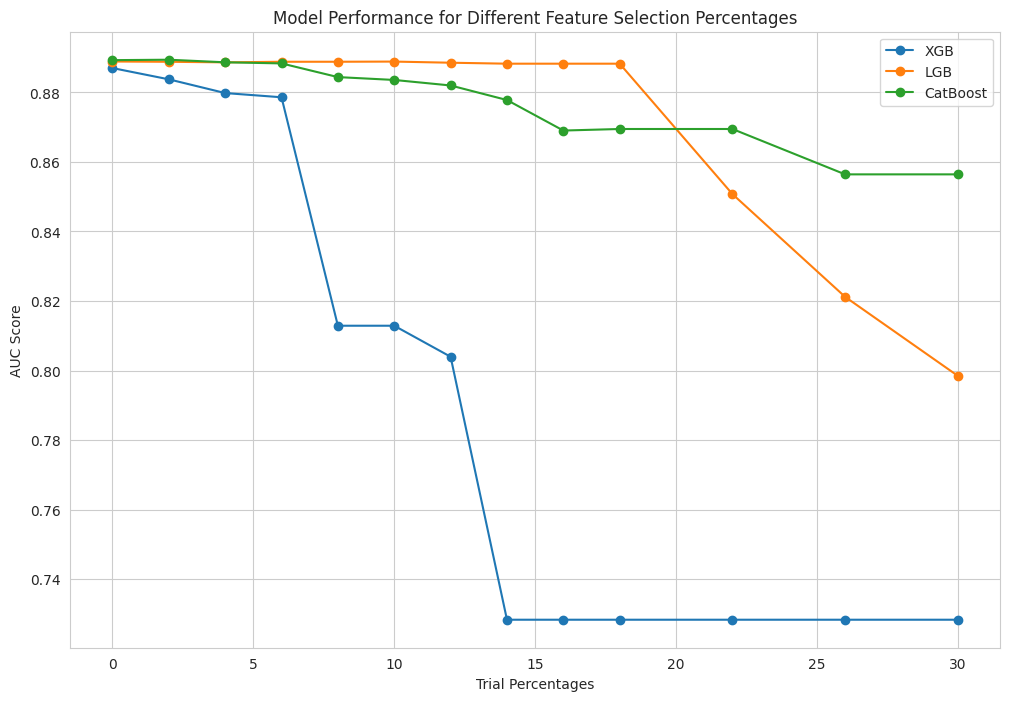

In [52]:
if submit == False:

    from xgboost import XGBClassifier
    import lightgbm as lgb
    from catboost import CatBoostClassifier
    from sklearn.metrics import roc_auc_score

    # List to store AUC scores for each trial percentage
    auc_scores = []

    # List to store selected features for each model and trial percentage
    selected_features_xgb = []
    selected_features_lgb = []
    selected_features_cat = []

    # List of trial percentages
    trial_percentages = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 22, 26, 30]

    # Loop over each trial percentage
    for percentage in trial_percentages:
        # Get selected features for each model
        xgb_selected_features = display_feature_importance(XGBClassifier(), percentage=percentage)
        lgb_selected_features = display_feature_importance(lgb.LGBMClassifier(), percentage=percentage)
        cat_selected_features = display_feature_importance(CatBoostClassifier(), percentage=percentage)

        # Append selected features to the respective lists
        selected_features_xgb.append(xgb_selected_features)
        selected_features_lgb.append(lgb_selected_features)
        selected_features_cat.append(cat_selected_features)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Fit models on training data
        xgb_model = XGBClassifier()
        lgb_model = lgb.LGBMClassifier()
        cat_model = CatBoostClassifier()

        xgb_model.fit(X_train[[feature for feature in xgb_selected_features if feature != 'Exited']], y_train, verbose=0)
        lgb_model.fit(X_train[[feature for feature in lgb_selected_features if feature != 'Exited']], y_train)
        cat_model.fit(X_train[[feature for feature in cat_selected_features if feature != 'Exited']], y_train, verbose=0)

        # Predict probabilities on the test set
        xgb_pred_proba = xgb_model.predict_proba(X_test[[feature for feature in xgb_selected_features if feature != 'Exited']])[:, 1]
        lgb_pred_proba = lgb_model.predict_proba(X_test[[feature for feature in lgb_selected_features if feature != 'Exited']])[:, 1]
        cat_pred_proba = cat_model.predict_proba(X_test[[feature for feature in cat_selected_features if feature != 'Exited']])[:, 1]

        # Calculate AUC scores and append to the list
        auc_xgb = roc_auc_score(y_test, xgb_pred_proba)
        auc_lgb = roc_auc_score(y_test, lgb_pred_proba)
        auc_cat = roc_auc_score(y_test, cat_pred_proba)

        auc_scores.append((auc_xgb, auc_lgb, auc_cat))

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plotting lines for each model
    plt.plot(trial_percentages, [auc[0] for auc in auc_scores], label='XGB', marker='o')
    plt.plot(trial_percentages, [auc[1] for auc in auc_scores], label='LGB', marker='o')
    plt.plot(trial_percentages, [auc[2] for auc in auc_scores], label='CatBoost', marker='o')

    plt.xlabel('Trial Percentages')
    plt.ylabel('AUC Score')
    plt.title('Model Performance for Different Feature Selection Percentages')
    plt.legend()
    plt.show()

**Purpose and Utility of the code above:**
This procedure allows us to empirically determine the optimal threshold for feature selection that balances model complexity and performance.

By evaluating model performance across a range of feature selection thresholds, you can make informed decisions about which features are truly important and streamline the model for efficiency and effectiveness.

The output of this code will provide a clear graphical representation of how different levels of feature inclusion impact the prediction accuracy of each model, helping to optimize feature selection strategies.

Below we can see the features and their importance based on a model

מטרה ושימושיות של הקוד לעיל: הליך זה מאפשר לנו לקבוע באופן אמפירי את הסף האופטימלי לבחירת תכונה שמאזנת בין מורכבות המודל לביצועים.

על ידי הערכת ביצועי המודל על פני מגוון ספי בחירת תכונות, אתה יכול לקבל החלטות מושכלות לגבי התכונות החשובות באמת ולייעל את המודל ליעילות ואפקטיביות.

הפלט של קוד זה יספק ייצוג גרפי ברור של האופן שבו רמות שונות של הכללת תכונות משפיעות על דיוק החיזוי של כל מודל, ועוזרת באופטימיזציה של אסטרטגיות בחירת תכונות.

להלן נוכל לראות את התכונות ואת חשיבותן בהתבסס על מודל

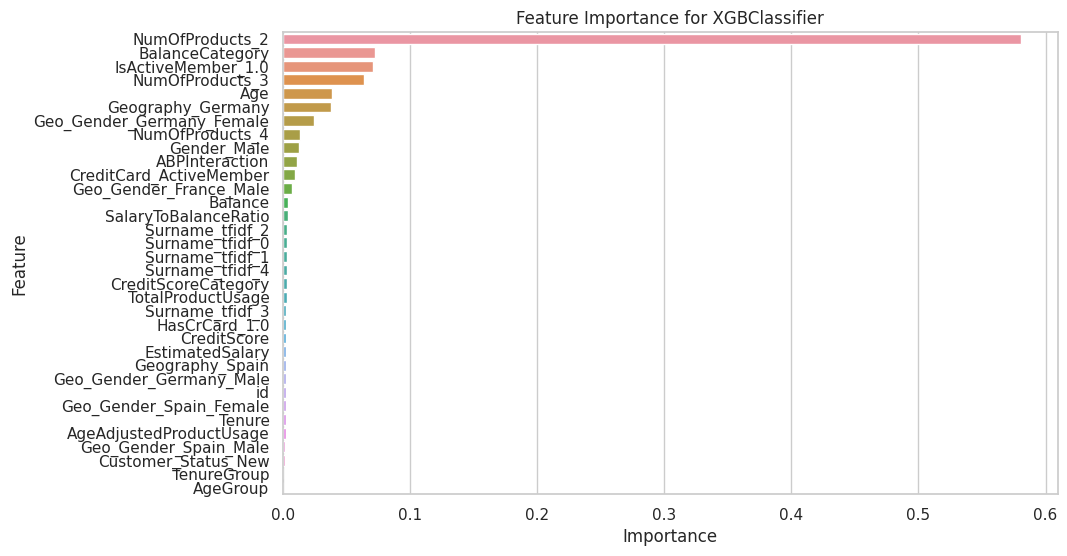

Selected Features at threshold 0%; ['NumOfProducts_2', 'BalanceCategory', 'IsActiveMember_1.0', 'NumOfProducts_3', 'Age', 'Geography_Germany', 'Geo_Gender_Germany_Female', 'NumOfProducts_4', 'Gender_Male', 'ABPInteraction', 'CreditCard_ActiveMember', 'Geo_Gender_France_Male', 'Balance', 'SalaryToBalanceRatio', 'Surname_tfidf_2', 'Surname_tfidf_0', 'Surname_tfidf_1', 'Surname_tfidf_4', 'CreditScoreCategory', 'TotalProductUsage', 'Surname_tfidf_3', 'HasCrCard_1.0', 'CreditScore', 'EstimatedSalary', 'Geography_Spain', 'Geo_Gender_Germany_Male', 'id', 'Geo_Gender_Spain_Female', 'Tenure', 'AgeAdjustedProductUsage', 'Geo_Gender_Spain_Male', 'Customer_Status_New', 'TenureGroup', 'AgeGroup']


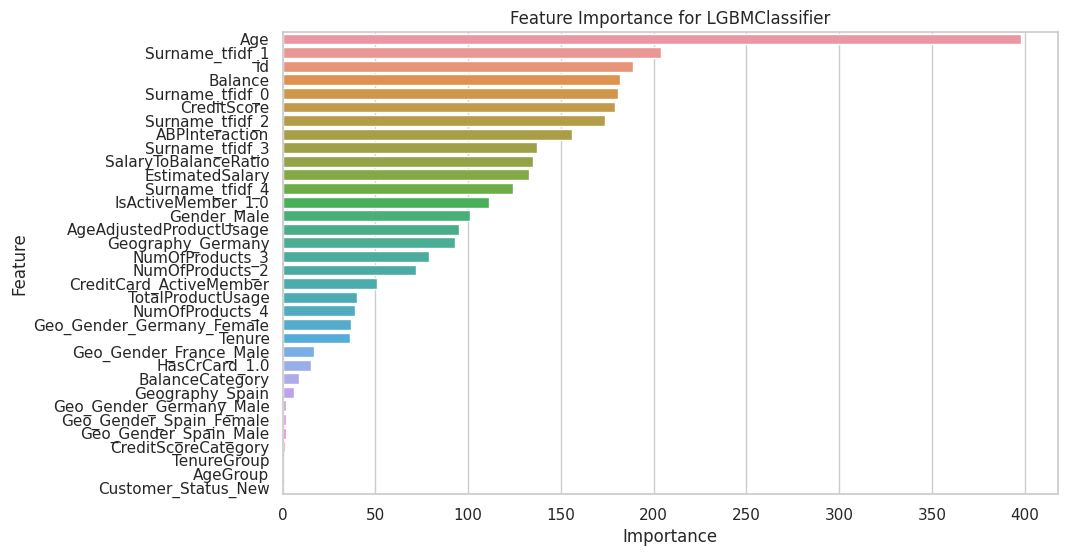

Selected Features at threshold 2%; ['Age', 'Surname_tfidf_1', 'id', 'Balance', 'Surname_tfidf_0', 'CreditScore', 'Surname_tfidf_2', 'ABPInteraction', 'Surname_tfidf_3', 'SalaryToBalanceRatio', 'EstimatedSalary', 'Surname_tfidf_4', 'IsActiveMember_1.0', 'Gender_Male', 'AgeAdjustedProductUsage', 'Geography_Germany', 'NumOfProducts_3', 'NumOfProducts_2', 'CreditCard_ActiveMember', 'TotalProductUsage', 'NumOfProducts_4', 'Geo_Gender_Germany_Female', 'Tenure', 'Geo_Gender_France_Male', 'HasCrCard_1.0', 'BalanceCategory']


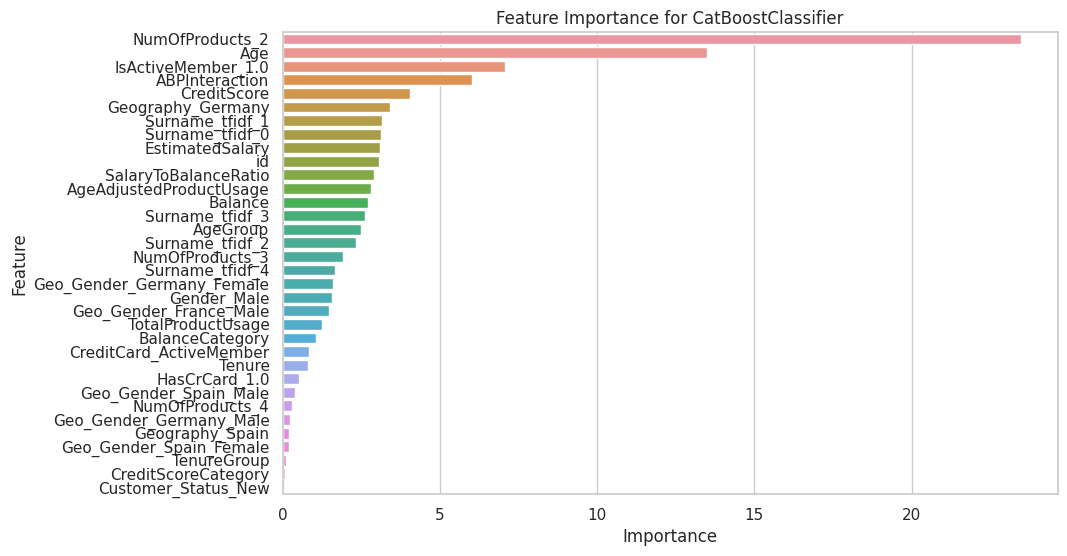

Selected Features at threshold 0%; ['NumOfProducts_2', 'Age', 'IsActiveMember_1.0', 'ABPInteraction', 'CreditScore', 'Geography_Germany', 'Surname_tfidf_1', 'Surname_tfidf_0', 'EstimatedSalary', 'id', 'SalaryToBalanceRatio', 'AgeAdjustedProductUsage', 'Balance', 'Surname_tfidf_3', 'AgeGroup', 'Surname_tfidf_2', 'NumOfProducts_3', 'Surname_tfidf_4', 'Geo_Gender_Germany_Female', 'Gender_Male', 'Geo_Gender_France_Male', 'TotalProductUsage', 'BalanceCategory', 'CreditCard_ActiveMember', 'Tenure', 'HasCrCard_1.0', 'Geo_Gender_Spain_Male', 'NumOfProducts_4', 'Geo_Gender_Germany_Male', 'Geography_Spain', 'Geo_Gender_Spain_Female', 'TenureGroup', 'CreditScoreCategory', 'Customer_Status_New']


In [53]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_selected_features = display_feature_importance(xgb_model, percentage=0, plot=True)

import lightgbm as lgb
lgb_model = lgb.LGBMClassifier()
lgb_selected_features = display_feature_importance(lgb_model, percentage=2, plot=True)

from catboost import CatBoostClassifier
cat_model = CatBoostClassifier()
cb_selected_features = display_feature_importance(cat_model, percentage=0,  plot=True)

**Model building and evaluation**

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# Set a seed for reproducibility
seed = 42

# Initialize all the classification models in the requested format
log_reg = LogisticRegression(random_state=seed, max_iter=1000000)
svc = SVC(random_state=seed, probability=True)
lda = LinearDiscriminantAnalysis()
gnb = GaussianNB()
bnb = BernoulliNB()
knn = KNeighborsClassifier()
gauss = GaussianProcessClassifier(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
et = ExtraTreesClassifier(random_state=seed)
xgb = XGBClassifier(random_state=seed)
lgb = LGBMClassifier(random_state=seed)
dart = LGBMClassifier(random_state=seed, boosting_type='dart')
cb = CatBoostClassifier(random_state=seed, verbose=0)
gb = GradientBoostingClassifier(random_state=seed)
hgb = HistGradientBoostingClassifier(random_state=seed)

Here's a concise explanation of each parameter used in the initialization of the classification models in the code:

1. **LogisticRegression**:
   - `random_state`: Ensures reproducibility of your model training by setting a seed for the random number generator.
   - `max_iter`: Sets the maximum number of iterations taken for the solvers to converge.

2. **SVC**:
   - `random_state`: Same as above, ensures reproducibility.
   - `probability`: When set to True, allows the model to provide probability estimates for the predictions, which is necessary for calculating metrics like AUC.

3. **LinearDiscriminantAnalysis**:
   - No parameters specified; uses default settings.

4. **GaussianNB**:
   - No parameters specified; Gaussian Naive Bayes doesn't typically need hyperparameter tuning for basic uses.

5. **BernoulliNB**:
   - No parameters specified; uses default settings for Bernoulli Naive Bayes, which is used for binary/boolean features.

6. **KNeighborsClassifier**:
   - No parameters specified; uses default settings, typically Euclidean distance and 5 neighbors.

7. **GaussianProcessClassifier**:
   - `random_state`: Ensures reproducibility of the random processes within the Gaussian Process.

8. **RandomForestClassifier**:
   - `random_state`: Ensures that the random selection of features and splitting points is consistent across different runs.

9. **ExtraTreesClassifier**:
   - `random_state`: Ensures consistency in the randomness of the forest building process.

10. **XGBClassifier**:
    - `random_state`: Ensures that the results are the same each time the model is trained with the same input data.

11. **LGBMClassifier** (standard):
    - `random_state`: Ensures reproducibility.
   
12. **LGBMClassifier** (DART):
    - `random_state`: Same as above.
    - `boosting_type`: 'dart' refers to Dropouts meet Multiple Additive Regression Trees, an algorithm that helps reduce overfitting and improve model robustness.

13. **CatBoostClassifier**:
    - `random_state`: Ensures reproducibility.
    - `verbose`: Controls verbosity of the output during training, set to 0 to prevent printing training progress.

14. **GradientBoostingClassifier**:
    - `random_state`: Ensures that the stochastic aspects of the model, like feature selection, are reproducible.

15. **HistGradientBoostingClassifier**:
    - `random_state`: Ensures reproducibility in operations like binning features.

These parameters help control the behavior of the models, affecting aspects such as convergence, computational efficiency, model accuracy, and reproducibility of results.

### מטרת הקוד:
- הקוד מעתיק למערכת את המודלים הנדרשים לביצוע ניסויים בקלאסיפיקציה, כאשר הוא מספ

ק בסיס להשוואה ביניהם תחת הגדרות מוגדרות מראש. זהו בסיס נהדר לפרויקט למידת מכונה שבו רוצים להשוות בין שיטות שונות על אותו סט נתונים.

Here's a concise explanation of each parameter used in the initialization of the classification models in the code:

LogisticRegression:

random_state: Ensures reproducibility of your model training by setting a seed for the random number generator.
max_iter: Sets the maximum number of iterations taken for the solvers to converge.
SVC:

random_state: Same as above, ensures reproducibility.
probability: When set to True, allows the model to provide probability estimates for the predictions, which is necessary for calculating metrics like AUC.
LinearDiscriminantAnalysis:

No parameters specified; uses default settings.
GaussianNB:

No parameters specified; Gaussian Naive Bayes doesn't typically need hyperparameter tuning for basic uses.
BernoulliNB:

No parameters specified; uses default settings for Bernoulli Naive Bayes, which is used for binary/boolean features.
KNeighborsClassifier:

No parameters specified; uses default settings, typically Euclidean distance and 5 neighbors.
GaussianProcessClassifier:

random_state: Ensures reproducibility of the random processes within the Gaussian Process.
RandomForestClassifier:

random_state: Ensures that the random selection of features and splitting points is consistent across different runs.
ExtraTreesClassifier:

random_state: Ensures consistency in the randomness of the forest building process.
XGBClassifier:

random_state: Ensures that the results are the same each time the model is trained with the same input data.
LGBMClassifier (standard):

random_state: Ensures reproducibility.
LGBMClassifier (DART):

random_state: Same as above.
boosting_type: 'dart' refers to Dropouts meet Multiple Additive Regression Trees, an algorithm that helps reduce overfitting and improve model robustness.
CatBoostClassifier:

random_state: Ensures reproducibility.
verbose: Controls verbosity of the output during training, set to 0 to prevent printing training progress.
GradientBoostingClassifier:

random_state: Ensures that the stochastic aspects of the model, like feature selection, are reproducible.
HistGradientBoostingClassifier:

random_state: Ensures reproducibility in operations like binning features.
These parameters help control the behavior of the models, affecting aspects such as convergence, computational efficiency, model accuracy, and reproducibility of results.

**Optuna Hyperparameter Tuning**
The purpose of the code is to use the Optuna library to perform hyperparameter optimization for a CatBoostClassifier, XGB and LGB models aimed at maximizing the Area Under the Curve (AUC) score for a binary classification task. Here’s a detailed explanation of each part of the code:

Optuna Study:

An Optuna study is created to maximize the AUC score ('maximize'). The study calls the objective function for a defined number of trials (n_trials=20), systematically exploring different combinations of parameters to find the best setup.
After optimization, it prints out the results, including the best AUC score achieved and the parameters that led to this score.
Summary:

This part of code effectively uses hyperparameter tuning to find the best configuration for a CatBoostClassifier on a given dataset, aiming to optimize prediction accuracy as assessed by the AUC metric. The use of Optuna allows for efficient exploration of the parameter space.
The outcome helps in understanding which parameters work best for the model on this specific dataset, potentially leading to improved model performance when applied to similar tasks or datasets.

כוונון היפרפרמטרים של Optuna מטרת הקוד היא להשתמש בספריית Optuna כדי לבצע אופטימיזציה של פרמטרים יתר עבור דגמי CatBoostClassifier, XGB ו- LGB שמטרתם למקסם את ציון השטח מתחת לעקומה (AUC) עבור משימת סיווג בינארי. להלן הסבר מפורט על כל חלק בקוד:

מחקר Optuna:

מחקר Optuna נוצר כדי למקסם את ציון ה-AUC ('מקסם'). המחקר קורא לפונקציה האובייקטיבית עבור מספר מוגדר של ניסויים (n_trials=20), בוחן באופן שיטתי שילובים שונים של פרמטרים כדי למצוא את ההגדרה הטובה ביותר. לאחר אופטימיזציה, הוא מדפיס את התוצאות, כולל ציון ה-AUC הטוב ביותר שהושג והפרמטרים שהובילו לציון זה. סיכום:

חלק זה של הקוד משתמש ביעילות בכוונון היפרפרמטרים כדי למצוא את התצורה הטובה ביותר עבור CatBoostClassifier במערך נתונים נתון, במטרה לייעל את דיוק הניבוי כפי שהוערך על ידי מדד AUC. השימוש ב-Optuna מאפשר חקירה יעילה של מרחב הפרמטרים. התוצאה עוזרת להבין אילו פרמטרים עובדים בצורה הטובה ביותר עבור המודל במערך הנתונים הספציפי הזה, מה שעלול להוביל לשיפור ביצועי המודל כאשר מיושמים על משימות או מערכי נתונים דומים.

In [55]:
!pip install optuna

Optuna Hyperparameter Tuning for Catboost

In [56]:
if submit==False:

    import optuna
    from catboost import CatBoostClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score

    # Assuming 'X' is your feature matrix and 'y' is your target variable
    X = train_data_combined[cb_selected_features].drop('Exited', axis=1)
    y = train_data_combined['Exited']

    def objective(trial):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        params = {
            'iterations': trial.suggest_int('iterations', 200, 1000),
            'depth': trial.suggest_int('depth', 3, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log=True),
            'random_state': 42,
            'verbose': 0,
            'eval_metric': 'AUC',
        }

        model = CatBoostClassifier(**params)

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        return auc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    print('Number of finished trials: ', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('Value: ', trial.value)
    print('Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2024-09-01 04:51:34,641] A new study created in memory with name: no-name-c4708f30-affa-4b8d-b351-4566961c80c5
[I 2024-09-01 04:51:40,676] Trial 0 finished with value: 0.8796915095895131 and parameters: {'iterations': 952, 'depth': 10, 'min_data_in_leaf': 7, 'learning_rate': 0.0005481178438356442}. Best is trial 0 with value: 0.8796915095895131.
[I 2024-09-01 04:51:49,943] Trial 1 finished with value: 0.8884480613064123 and parameters: {'iterations': 513, 'depth': 6, 'min_data_in_leaf': 7, 'learning_rate': 0.1915977683863698}. Best is trial 1 with value: 0.8884480613064123.
[I 2024-09-01 04:52:30,542] Trial 2 finished with value: 0.8773249531448302 and parameters: {'iterations': 980, 'depth': 7, 'min_data_in_leaf': 18, 'learning_rate': 0.00027434265474025605}. Best is trial 1 with value: 0.8884480613064123.
[I 2024-09-01 04:52:58,903] Trial 3 finished with value: 0.8761634763606031 and parameters: {'iterations': 990, 'depth': 4, 'min_data_in_leaf': 8, 'learning_rate': 0.001687449561

Number of finished trials:  20
Best trial:
Value:  0.8893155385838477
Params: 
    iterations: 997
    depth: 6
    min_data_in_leaf: 19
    learning_rate: 0.04574559706754876


In [57]:
if submit==False:

    import optuna
    from catboost import CatBoostClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score

    # Assuming 'X' is your feature matrix and 'y' is your target variable
    X = train_data_combined[cb_selected_features].drop('Exited', axis=1)
    y = train_data_combined['Exited']

    def objective(trial):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        params = {
            'iterations': trial.suggest_int('iterations', 200, 1000),
            'depth': trial.suggest_int('depth', 3, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log=True),
            'random_state': 42,
            'verbose': 0,
            'eval_metric': 'AUC',
        }

        model = CatBoostClassifier(**params)

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        return auc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    print('Number of finished trials: ', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('Value: ', trial.value)
    print('Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2024-09-01 04:58:14,131] A new study created in memory with name: no-name-d9cbe6b5-8682-47a3-ae51-5b678b4b5d6c
[I 2024-09-01 04:58:17,354] Trial 0 finished with value: 0.8744004237511555 and parameters: {'iterations': 416, 'depth': 6, 'min_data_in_leaf': 11, 'learning_rate': 0.00012547535533193496}. Best is trial 0 with value: 0.8744004237511555.
[I 2024-09-01 04:58:36,182] Trial 1 finished with value: 0.8788046005157133 and parameters: {'iterations': 445, 'depth': 7, 'min_data_in_leaf': 18, 'learning_rate': 0.0014788773402701959}. Best is trial 1 with value: 0.8788046005157133.
[I 2024-09-01 04:58:40,193] Trial 2 finished with value: 0.8705769401145164 and parameters: {'iterations': 703, 'depth': 5, 'min_data_in_leaf': 14, 'learning_rate': 0.00012143845752085784}. Best is trial 1 with value: 0.8788046005157133.
[I 2024-09-01 04:58:57,367] Trial 3 finished with value: 0.8817024582886166 and parameters: {'iterations': 612, 'depth': 4, 'min_data_in_leaf': 14, 'learning_rate': 0.006890

Number of finished trials:  20
Best trial:
Value:  0.8893095049890565
Params: 
    iterations: 871
    depth: 7
    min_data_in_leaf: 7
    learning_rate: 0.06300897582285193


# Result explanation
## The explanation was done for one of the tests we ran while working on this project. But based on this explanation we can better understand the output of the code.

The output from this Optuna hyperparameter optimization shows the results of tuning a CatBoostClassifier model.

### Summary

1. **Number of Trials**: A total of 20 trials were completed, each testing different combinations of parameters to find the most effective setup for the model.

2. **Best Trial Outcome**:
   - **AUC Score**: The highest Area Under the Curve (AUC) score achieved among all the trials was approximately 0.889. This score is quite good, indicating that the model has a strong ability to distinguish between the classes (likely 'Exited' or not). An AUC score of 1 represents perfect prediction, while 0.5 would be no better than random guessing.
   
3. **Optimal Parameters**: The parameters that led to this highest AUC score are:
   - **Iterations**: 641 - This is the number of boosting stages the model went through to build the trees. More iterations can allow for more complex models, but also risk overfitting.
   - **Depth**: 6 - This represents the maximum depth of the trees. A depth of 6 allows the model to capture complex patterns in the data, but is still moderate enough to control overfitting.
   - **Min Data in Leaf**: 2 - This is the minimum number of samples required to be at a leaf node. A small number allows the model to learn fine-grained patterns.
   - **Learning Rate**: Approximately 0.093 - This is the step size used for updating the weights after each iteration. A moderate learning rate of 0.093 balances the speed of convergence and the risk of overshooting the optimal weights.

This output gives us insights into the best performing model configuration for our dataset as identified through the optimization process. It suggests that the model parameters found are quite effective for predicting the target variable in our dataset. Using these parameters, we can expect the model to perform well, assuming the test conditions are similar to the validation setup used during the hyperparameter optimization.

ניתוח גורמים ראשיים Principal Component Analysis (PCA) היא טכניקה בה אנו משתמשים כדי להפחית את הממדיות (= מספר הפיצ'רים) של מערכי נתונים גדולים תוך שמירה על רוב השונות. כאשר, נא לזכור, השונות היא מה שמעניין אותנו במערך הנתונים. הפחתת מימדיות מקריבה דיוק ומעניקה פשטות. התוצאה היא נתונים פחות מדויקים, אבל כאלה שאנחנו יכולים בקלות לצייר מהם תרשים או להשתמש בהם כדי לאמן את המודלים שלנו בזמן קצר יותר. חשוב להבין, שהטכניקה לא משתמשת בממדים הקיימים אלא מארגנת את המידע באופן שיוצר ממדים חדשים קומפקטיים שמצליחים להכיל את המידע במספר מצומצם של ממדים דחוסים.

**Step 3:#PCA** 

#Standardize the Data

#This ensures that each feature contributes equally to the analysis.

In [58]:
####PCA
# scaler = StandardScaler()

# scaled_data = scaler.fit_transform(train_data_combined[cb_selected_features])  # Assuming 'data' is your DataFrame




### שלב 4: ביצוע PCA
```python
pca = PCA(n_components=2)  # Reduce to two dimensions, for example
principal_components = pca.fit_transform(scaled_data)
```

#### פעולות מרכזיות בשלב זה:
1. **אתחול והגדרת מודל PCA:** 
   - `pca = PCA(n_components=2)` - בשורה זו אנו יוצרים אינסטנס של המחלקה `PCA`, כאשר `n_components=2` מציין שאנו רוצים להקטין את ממדי הנתונים לשני ממדים עיקריים. זהו מספר הרכיבים החדשים שאנו רוצים להשיג בעקבות ההקטנה.

2. **למידה והתאמה של המודל לנתונים (`fit`), והפעלת הטרנספורמציה (`transform`):**
   - `principal_components = pca.fit_transform(scaled_data)` - שיטה זו משלבת שני צעדים בתהליך אחד:
     - `fit` - מתאים את המודל לנתונים, כלומר, מחשב את וקטורי היחידה וערכים עצמיים שמקסימים את השונות בנתונים. במילים אחרות, מוצא את הכיוונים (הרכיבים העיקריים) שבהם הנתונים מפגינים את השונות הגבוהה ביותר.
     - `transform` - מקדם את הנתונים למרחב הרכיבים העיקריים שהתגלו. כלומר, מטיל את הנתונים המקוריים על הרכיבים העיקריים שנמצאו וממיר אותם למערכת קואורדינטות חדשה עם מספר ממדים נמוך יותר.

#### תוצאה:
- התוצאה, `principal_components`, היא מערך של נתונים שהופחתו לשני ממדים, כאשר כל שורה מייצגת דגימה במערכת הנתונים המקורית וכל עמודה מייצגת אחד משני הרכיבים העיקריים.

באמצעות צעד זה אנו מקבלים תצוגה מקוצרת וממוקדת יותר של הנתונים, שמשמרת את המידע החשוב ביותר מבחינת שונות עם מספר מצומצם של ממדים. זהו כלי חזק לוויזואליזציה, ניתוח נתונים," (curse of dimensionality) ועודפת ממדים.

**Step 4:#PCA** Apply PCA

You can choose the number of principal components by setting the n_components parameter. If you're not sure how many components to keep, you can run PCA by setting n_components to None, which will return the variance ratio for each component.

In [59]:
#pca = PCA(n_components=2)  # Reduce to two dimensions, for example
#principal_components = pca.fit_transform(scaled_data)

# from sklearn.impute import SimpleImputer

# יצירת משלים עם הערך הממוצע
# imputer = SimpleImputer(strategy='mean')

# החלת המשלים על הנתונים
# scaled_data = imputer.fit_transform(scaled_data)

# עכשיו אפשר להמשיך ולבצע PCA
# pca = PCA(n_components=2)
# principal_components = pca.fit_transform(scaled_data)



**Step 5:#PCA** Explained Variance Ratio


To understand how much variance each principal component holds, you can check the explained_variance_ratio_ attribute.

In [60]:
# print(pca.explained_variance_ratio_)


**Step 6:#PCA** Visualization (Optional)

To visualize the results of PCA (if you reduced to two or three dimensions), you can plot the principal components as follows:

In [61]:
# plt.figure(figsize=(8,6))
# plt.scatter(principal_components[:,0], principal_components[:,1], c=train_data_combined['Exited'], cmap='plasma')
# plt.xlabel('First principal component')
# plt.ylabel('Second principal component')
# plt.colorbar()
# plt.show()


**Choosing the Number of Components**

To decide how many components to use, you can look at the cumulative explained variance ratio as a function of the number of components. This can be plotted to see at what point additional components stop adding significant information.

In [62]:
# pca = PCA().fit(scaled_data)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('number of components')
# plt.ylabel('cumulative explained variance')
# plt.show()


**XGB Optuna Hyperparameter Tuning**

In [63]:
if submit == False:
    import optuna
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score

    # Assuming 'X' is your feature matrix and 'y' is your target variable
    X = train_data_combined[xgb_selected_features].drop('Exited', axis=1)
    y = train_data_combined['Exited']

    def objective(trial):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        params = {
            'max_depth': trial.suggest_int('max_depth', 5, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
            'subsample': trial.suggest_float('subsample', 0.01, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
            'random_state': trial.suggest_categorical('random_state', [42]),
            'tree_method': 'hist',  # Use GPU for training
            'device': 'cuda',
            'eval_metric': 'auc',  # Evaluation metric
            'verbosity': 2,  # Set verbosity to 0 for less output
        }

        model = XGBClassifier(**params)

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        return auc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    print('Number of finished trials: ', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('Value: ', trial.value)
    print('Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2024-09-01 05:05:06,534] A new study created in memory with name: no-name-6143c410-1049-483a-8809-f6a8cb17b71a
[I 2024-09-01 05:05:16,507] Trial 0 finished with value: 0.8734498120520542 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'learning_rate': 0.4337239188390757, 'n_estimators': 775, 'subsample': 0.05243702912690723, 'colsample_bytree': 0.6799352284125743, 'random_state': 42}. Best is trial 0 with value: 0.8734498120520542.
[I 2024-09-01 05:05:28,165] Trial 1 finished with value: 0.8707481146178465 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'learning_rate': 0.6209065578599625, 'n_estimators': 457, 'subsample': 0.21643489059701962, 'colsample_bytree': 0.9964916618506089, 'random_state': 42}. Best is trial 0 with value: 0.8734498120520542.
[I 2024-09-01 05:05:40,877] Trial 2 finished with value: 0.8872423846479315 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'learning_rate': 0.25643984066375924, 'n_estimators': 668, 'subsample': 0.745512497318

Number of finished trials:  20
Best trial:
Value:  0.8892237648178152
Params: 
    max_depth: 5
    min_child_weight: 6
    learning_rate: 0.14809783946342284
    n_estimators: 867
    subsample: 0.5169162314747847
    colsample_bytree: 0.536729277629165
    random_state: 42


LGB Optuna Hyperparameter Tuning

In [64]:
if submit == False:
    import optuna
    import lightgbm as lgb
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_auc_score

    # Assuming 'X' is your feature matrix and 'y' is your target variable
    X = train_data_combined[lgb_selected_features].drop('Exited', axis=1)
    y = train_data_combined['Exited']

    def objective(trial):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'metric': 'auc',
            'max_depth': trial.suggest_int('max_depth', 5, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
            'random_state': 42,
        }

        model = lgb.LGBMClassifier(**params)

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(20)])

        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        return auc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    print('Number of finished trials: ', len(study.trials))
    print('Best trial:')
    trial = study.best_trial

    print('Value: ', trial.value)
    print('Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')

[I 2024-09-01 05:10:31,927] A new study created in memory with name: no-name-f0b3f9c2-9bea-4f22-903e-6f5a6b12184d


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[356]	valid_0's au

[I 2024-09-01 05:10:44,543] Trial 0 finished with value: 0.8902536671521191 and parameters: {'max_depth': 10, 'min_child_samples': 18, 'learning_rate': 0.06663442186292252, 'n_estimators': 715, 'subsample': 0.5316325101307935, 'colsample_bytree': 0.4378090039419297, 'reg_alpha': 0.9951899167239706, 'reg_lambda': 0.7507681242987767}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[97]	valid_0's auc

[I 2024-09-01 05:10:50,948] Trial 1 finished with value: 0.8888667746792682 and parameters: {'max_depth': 7, 'min_child_samples': 16, 'learning_rate': 0.15645957352534576, 'n_estimators': 783, 'subsample': 0.4851814857102157, 'colsample_bytree': 0.9519757204584445, 'reg_alpha': 0.5384171869695843, 'reg_lambda': 0.029928825160816963}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:10:53,027] Trial 2 finished with value: 0.8828210392967344 and parameters: {'max_depth': 10, 'min_child_samples': 15, 'learning_rate': 0.7485489057550526, 'n_estimators': 393, 'subsample': 0.39594074702338034, 'colsample_bytree': 0.6065035828257357, 'reg_alpha': 0.40699291506837765, 'reg_lambda': 0.4265421922586413}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[17]	valid_0's auc: 0.882821
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:10:55,602] Trial 3 finished with value: 0.8843769678455641 and parameters: {'max_depth': 5, 'min_child_samples': 8, 'learning_rate': 0.5334625910051063, 'n_estimators': 979, 'subsample': 0.6361383638064558, 'colsample_bytree': 0.305356006304055, 'reg_alpha': 0.3836873916445318, 'reg_lambda': 0.3177258552913499}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from 

[I 2024-09-01 05:10:57,615] Trial 4 finished with value: 0.8820755086527157 and parameters: {'max_depth': 7, 'min_child_samples': 2, 'learning_rate': 0.8953798877694764, 'n_estimators': 350, 'subsample': 0.16327483290794326, 'colsample_bytree': 0.981177203601611, 'reg_alpha': 0.32818804642995225, 'reg_lambda': 0.26453017256935574}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[7]	valid_0's auc: 0.882076
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.21106

[I 2024-09-01 05:11:03,294] Trial 5 finished with value: 0.8875251023600825 and parameters: {'max_depth': 10, 'min_child_samples': 14, 'learning_rate': 0.16085505802637895, 'n_estimators': 326, 'subsample': 0.6677661778885974, 'colsample_bytree': 0.14720629873596827, 'reg_alpha': 0.24798683203596483, 'reg_lambda': 0.8058860193455788}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:11:05,432] Trial 6 finished with value: 0.8828443687072525 and parameters: {'max_depth': 7, 'min_child_samples': 1, 'learning_rate': 0.7513931084152004, 'n_estimators': 160, 'subsample': 0.8531969807063102, 'colsample_bytree': 0.6010318879960039, 'reg_alpha': 0.3709910817448263, 'reg_lambda': 0.7718631126471439}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[18]	valid_0's auc: 0.882844
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:11:07,640] Trial 7 finished with value: 0.8816043646623462 and parameters: {'max_depth': 8, 'min_child_samples': 20, 'learning_rate': 0.8278795265937817, 'n_estimators': 470, 'subsample': 0.20107872034270952, 'colsample_bytree': 0.6266796547329988, 'reg_alpha': 0.35768911845835183, 'reg_lambda': 0.9070296577533055}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[15]	valid_0's auc: 0.881604
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:11:10,220] Trial 8 finished with value: 0.8868180707485231 and parameters: {'max_depth': 10, 'min_child_samples': 3, 'learning_rate': 0.365979126918324, 'n_estimators': 214, 'subsample': 0.662991588590258, 'colsample_bytree': 0.1844359363370565, 'reg_alpha': 0.7910694051766588, 'reg_lambda': 0.27842747435503223}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[44]	valid_0's auc: 0.886818
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:11:12,759] Trial 9 finished with value: 0.8852913877627687 and parameters: {'max_depth': 5, 'min_child_samples': 8, 'learning_rate': 0.5811943599322617, 'n_estimators': 904, 'subsample': 0.38293742039823775, 'colsample_bytree': 0.5685085583280958, 'reg_alpha': 0.15242143619737836, 'reg_lambda': 0.6247001224461711}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[32]	valid_0's auc: 0.885291
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leav

[I 2024-09-01 05:11:15,833] Trial 10 finished with value: 0.8882402643996596 and parameters: {'max_depth': 9, 'min_child_samples': 19, 'learning_rate': 0.32944237573590773, 'n_estimators': 673, 'subsample': 0.9775833309607729, 'colsample_bytree': 0.4284723271489969, 'reg_alpha': 0.9483362401693699, 'reg_lambda': 0.6150403995877239}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[51]	valid_0's auc: 0.88824
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.21106

[I 2024-09-01 05:11:27,655] Trial 11 finished with value: 0.8891194565399752 and parameters: {'max_depth': 8, 'min_child_samples': 16, 'learning_rate': 0.07182598678084066, 'n_estimators': 731, 'subsample': 0.4535757354726415, 'colsample_bytree': 0.8665724506222938, 'reg_alpha': 0.608804861818321, 'reg_lambda': 0.036013404421866485}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[387]	valid_0's au

[I 2024-09-01 05:11:45,658] Trial 12 finished with value: 0.8895855725346851 and parameters: {'max_depth': 8, 'min_child_samples': 11, 'learning_rate': 0.055857399177623085, 'n_estimators': 633, 'subsample': 0.31507932926543913, 'colsample_bytree': 0.79797161205571, 'reg_alpha': 0.6524168757293589, 'reg_lambda': 0.046687149821454874}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[581]

[I 2024-09-01 05:12:18,624] Trial 13 finished with value: 0.8884817378671223 and parameters: {'max_depth': 9, 'min_child_samples': 11, 'learning_rate': 0.014059179772248097, 'n_estimators': 581, 'subsample': 0.3036984314230391, 'colsample_bytree': 0.772943573434333, 'reg_alpha': 0.9485455236506249, 'reg_lambda': 0.5980274740452094}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:12:21,495] Trial 14 finished with value: 0.8882660894576583 and parameters: {'max_depth': 6, 'min_child_samples': 11, 'learning_rate': 0.29132439548283995, 'n_estimators': 604, 'subsample': 0.28483874379422736, 'colsample_bytree': 0.4100066175245441, 'reg_alpha': 0.7040182152991814, 'reg_lambda': 0.9940905536461659}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[41]	valid_0's auc: 0.888266
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:12:25,994] Trial 15 finished with value: 0.8883042728641128 and parameters: {'max_depth': 9, 'min_child_samples': 6, 'learning_rate': 0.20634031931996072, 'n_estimators': 804, 'subsample': 0.5729361132217292, 'colsample_bytree': 0.7602379135015394, 'reg_alpha': 0.0077359520134410165, 'reg_lambda': 0.14875054022117262}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[65]	valid_0's auc: 0.888304
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:12:28,553] Trial 16 finished with value: 0.8862584120141253 and parameters: {'max_depth': 8, 'min_child_samples': 13, 'learning_rate': 0.48138556882238825, 'n_estimators': 499, 'subsample': 0.7868033800740821, 'colsample_bytree': 0.46283372784959403, 'reg_alpha': 0.8186697764853796, 'reg_lambda': 0.4967629537569911}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[35]	valid_0's auc: 0.886258
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:13:06,946] Trial 17 finished with value: 0.8879547990285668 and parameters: {'max_depth': 9, 'min_child_samples': 18, 'learning_rate': 0.010648775574206473, 'n_estimators': 671, 'subsample': 0.12697052505999112, 'colsample_bytree': 0.7232766294552172, 'reg_alpha': 0.9938248563953223, 'reg_lambda': 0.7976973031209215}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't 

[I 2024-09-01 05:13:08,817] Trial 18 finished with value: 0.8786809167159129 and parameters: {'max_depth': 6, 'min_child_samples': 5, 'learning_rate': 0.9956104279509976, 'n_estimators': 881, 'subsample': 0.25612457028185015, 'colsample_bytree': 0.3026766412410893, 'reg_alpha': 0.6701799337844347, 'reg_lambda': 0.40514746169814797}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[18]	valid_0's auc: 0.878681
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:13:12,262] Trial 19 finished with value: 0.8873454964830088 and parameters: {'max_depth': 10, 'min_child_samples': 9, 'learning_rate': 0.4385632284584845, 'n_estimators': 661, 'subsample': 0.5442976531558135, 'colsample_bytree': 0.6867504299611431, 'reg_alpha': 0.8012836737117555, 'reg_lambda': 0.6943833456943062}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[48]	valid_0's auc: 0.887345
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:13:16,281] Trial 20 finished with value: 0.8873191869757932 and parameters: {'max_depth': 6, 'min_child_samples': 12, 'learning_rate': 0.26848922384251617, 'n_estimators': 507, 'subsample': 0.3528916103860612, 'colsample_bytree': 0.31559227274533863, 'reg_alpha': 0.5386245838977742, 'reg_lambda': 0.16096208691336322}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[160]	valid_0's au

[I 2024-09-01 05:13:25,699] Trial 21 finished with value: 0.8893538247522574 and parameters: {'max_depth': 8, 'min_child_samples': 17, 'learning_rate': 0.09596971798630555, 'n_estimators': 734, 'subsample': 0.4649506627499351, 'colsample_bytree': 0.8790429733556854, 'reg_alpha': 0.6363565531659938, 'reg_lambda': 0.0036988639150928385}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[169]	valid_0's au

[I 2024-09-01 05:13:35,146] Trial 22 finished with value: 0.889262956270115 and parameters: {'max_depth': 8, 'min_child_samples': 17, 'learning_rate': 0.10081116989789418, 'n_estimators': 769, 'subsample': 0.4809218087294145, 'colsample_bytree': 0.8485121132915713, 'reg_alpha': 0.8728451234664432, 'reg_lambda': 0.13178311477210902}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:13:39,538] Trial 23 finished with value: 0.8880533722106277 and parameters: {'max_depth': 9, 'min_child_samples': 20, 'learning_rate': 0.2231389525311836, 'n_estimators': 849, 'subsample': 0.5656524118932034, 'colsample_bytree': 0.82358326445838, 'reg_alpha': 0.6990287406669341, 'reg_lambda': 8.403139927602547e-05}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[56]	valid_0's auc: 0.888053
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:13:48,100] Trial 24 finished with value: 0.889176572613298 and parameters: {'max_depth': 8, 'min_child_samples': 18, 'learning_rate': 0.1106516839000572, 'n_estimators': 628, 'subsample': 0.4473306063380069, 'colsample_bytree': 0.9383153661987205, 'reg_alpha': 0.617274253083397, 'reg_lambda': 0.11964091289491642}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:13:51,137] Trial 25 finished with value: 0.8877360041459065 and parameters: {'max_depth': 7, 'min_child_samples': 14, 'learning_rate': 0.3883991251738689, 'n_estimators': 730, 'subsample': 0.7345238434563779, 'colsample_bytree': 0.8978957073063907, 'reg_alpha': 0.7544762738524073, 'reg_lambda': 0.2365426421711367}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[27]	valid_0's auc: 0.887736
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:14:04,486] Trial 26 finished with value: 0.8894787049948206 and parameters: {'max_depth': 9, 'min_child_samples': 16, 'learning_rate': 0.05324444936830401, 'n_estimators': 535, 'subsample': 0.33575025072845277, 'colsample_bytree': 0.6692763091857934, 'reg_alpha': 0.8909976024683186, 'reg_lambda': 0.3873260566795057}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	valid_0's auc

[I 2024-09-01 05:14:08,649] Trial 27 finished with value: 0.8883539974168091 and parameters: {'max_depth': 10, 'min_child_samples': 13, 'learning_rate': 0.2047953752904848, 'n_estimators': 523, 'subsample': 0.20811770563472723, 'colsample_bytree': 0.5338257935717348, 'reg_alpha': 0.8831675981346312, 'reg_lambda': 0.3892491276638099}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[430]

[I 2024-09-01 05:14:27,822] Trial 28 finished with value: 0.8894057440067087 and parameters: {'max_depth': 9, 'min_child_samples': 10, 'learning_rate': 0.025466108254313388, 'n_estimators': 431, 'subsample': 0.34039385858834653, 'colsample_bytree': 0.5014363114105457, 'reg_alpha': 0.8657724775095794, 'reg_lambda': 0.48537974351442514}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[163]	valid_0's au

[I 2024-09-01 05:14:34,010] Trial 29 finished with value: 0.8895902555437812 and parameters: {'max_depth': 9, 'min_child_samples': 15, 'learning_rate': 0.15391242587979187, 'n_estimators': 547, 'subsample': 0.4138608605847204, 'colsample_bytree': 0.36922224555476413, 'reg_alpha': 0.46643476927633115, 'reg_lambda': 0.7034005765133581}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[141]	valid_0's au

[I 2024-09-01 05:14:39,543] Trial 30 finished with value: 0.8890275286310099 and parameters: {'max_depth': 10, 'min_child_samples': 15, 'learning_rate': 0.16983081026096397, 'n_estimators': 557, 'subsample': 0.5299240551068986, 'colsample_bytree': 0.3707844403671281, 'reg_alpha': 0.49159335734113063, 'reg_lambda': 0.711803010234492}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[125]	valid_0's au

[I 2024-09-01 05:14:46,243] Trial 31 finished with value: 0.8892326855342021 and parameters: {'max_depth': 9, 'min_child_samples': 16, 'learning_rate': 0.1272053428917645, 'n_estimators': 574, 'subsample': 0.4038566134083327, 'colsample_bytree': 0.6650901978526395, 'reg_alpha': 0.4927796955786441, 'reg_lambda': 0.8734238317751204}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for

[I 2024-09-01 05:15:03,720] Trial 32 finished with value: 0.8897483866189547 and parameters: {'max_depth': 9, 'min_child_samples': 18, 'learning_rate': 0.06264860133604838, 'n_estimators': 635, 'subsample': 0.2521630598031997, 'colsample_bytree': 0.22455262373536045, 'reg_alpha': 0.9835107382470079, 'reg_lambda': 0.5488221392252678}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:15:06,003] Trial 33 finished with value: 0.8856112098808457 and parameters: {'max_depth': 10, 'min_child_samples': 18, 'learning_rate': 0.627337430137252, 'n_estimators': 688, 'subsample': 0.24881962298208146, 'colsample_bytree': 0.1849391868745413, 'reg_alpha': 0.5411756611133354, 'reg_lambda': 0.5327783250835828}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[36]	valid_0's auc: 0.885611
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_le

[I 2024-09-01 05:15:10,000] Trial 34 finished with value: 0.8876288307668901 and parameters: {'max_depth': 9, 'min_child_samples': 15, 'learning_rate': 0.27095423454274586, 'n_estimators': 629, 'subsample': 0.416238127964754, 'colsample_bytree': 0.2479478120855212, 'reg_alpha': 0.9912714536235263, 'reg_lambda': 0.7001936173005947}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive 

[I 2024-09-01 05:15:16,080] Trial 35 finished with value: 0.888911620485811 and parameters: {'max_depth': 10, 'min_child_samples': 19, 'learning_rate': 0.15277743390956888, 'n_estimators': 405, 'subsample': 0.13964394377599995, 'colsample_bytree': 0.10591347797348127, 'reg_alpha': 0.44344153457043606, 'reg_lambda': 0.5788180857804527}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[253]	valid_0's au

[I 2024-09-01 05:15:26,101] Trial 36 finished with value: 0.8899521733627458 and parameters: {'max_depth': 7, 'min_child_samples': 14, 'learning_rate': 0.07417005879687782, 'n_estimators': 797, 'subsample': 0.602677443566133, 'colsample_bytree': 0.3710014296974117, 'reg_alpha': 0.3167910483583594, 'reg_lambda': 0.6604216768508137}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	valid_0's auc

[I 2024-09-01 05:15:30,157] Trial 37 finished with value: 0.8886818325206697 and parameters: {'max_depth': 7, 'min_child_samples': 14, 'learning_rate': 0.2287824655665516, 'n_estimators': 964, 'subsample': 0.5972102820871465, 'colsample_bytree': 0.3545321994231499, 'reg_alpha': 0.177348518727877, 'reg_lambda': 0.7560578343837001}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive 

[I 2024-09-01 05:15:35,195] Trial 38 finished with value: 0.8895427330329797 and parameters: {'max_depth': 7, 'min_child_samples': 17, 'learning_rate': 0.1683742234509292, 'n_estimators': 825, 'subsample': 0.6314763067924664, 'colsample_bytree': 0.2604021185768801, 'reg_alpha': 0.26219839620676794, 'reg_lambda': 0.8659918497591323}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive 

[I 2024-09-01 05:15:42,039] Trial 39 finished with value: 0.8887756810995099 and parameters: {'max_depth': 10, 'min_child_samples': 19, 'learning_rate': 0.11191971559406472, 'n_estimators': 303, 'subsample': 0.7136847604585874, 'colsample_bytree': 0.23066322595163125, 'reg_alpha': 0.3108658763221961, 'reg_lambda': 0.6478713098776134}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive 

[I 2024-09-01 05:15:44,420] Trial 40 finished with value: 0.8845939203531723 and parameters: {'max_depth': 6, 'min_child_samples': 13, 'learning_rate': 0.623207581184573, 'n_estimators': 783, 'subsample': 0.5109693964894869, 'colsample_bytree': 0.3879450474387696, 'reg_alpha': 0.4234925492092314, 'reg_lambda': 0.5498263799458984}. Best is trial 0 with value: 0.8902536671521191.


Early stopping, best iteration is:
[31]	valid_0's auc: 0.884594
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:15:55,592] Trial 41 finished with value: 0.8901260123367684 and parameters: {'max_depth': 7, 'min_child_samples': 12, 'learning_rate': 0.063219634743456, 'n_estimators': 703, 'subsample': 0.21503743480276444, 'colsample_bytree': 0.4651560980946634, 'reg_alpha': 0.22013665517331377, 'reg_lambda': 0.6677631494832826}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[285]	valid_0's au

[I 2024-09-01 05:16:07,165] Trial 42 finished with value: 0.8901402032734232 and parameters: {'max_depth': 7, 'min_child_samples': 14, 'learning_rate': 0.06142778255172761, 'n_estimators': 723, 'subsample': 0.18925036221341107, 'colsample_bytree': 0.4632095400929861, 'reg_alpha': 0.17507295997701883, 'reg_lambda': 0.6617782736832518}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[346]	valid_0's au

[I 2024-09-01 05:16:20,455] Trial 43 finished with value: 0.8900067008134858 and parameters: {'max_depth': 7, 'min_child_samples': 12, 'learning_rate': 0.05958664013593751, 'n_estimators': 713, 'subsample': 0.17584006943087813, 'colsample_bytree': 0.4571206130370243, 'reg_alpha': 0.12660570860480086, 'reg_lambda': 0.6562622041041652}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[315]	valid_0's au

[I 2024-09-01 05:16:32,977] Trial 44 finished with value: 0.8900763244847705 and parameters: {'max_depth': 7, 'min_child_samples': 12, 'learning_rate': 0.057819190404258, 'n_estimators': 714, 'subsample': 0.17336756926045588, 'colsample_bytree': 0.4695965323100549, 'reg_alpha': 0.061052510876333566, 'reg_lambda': 0.6526064008164559}. Best is trial 0 with value: 0.8902536671521191.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[536]	valid_0's au

[I 2024-09-01 05:16:52,116] Trial 45 finished with value: 0.8903078667432879 and parameters: {'max_depth': 7, 'min_child_samples': 12, 'learning_rate': 0.04212821669899762, 'n_estimators': 710, 'subsample': 0.18064316277349798, 'colsample_bytree': 0.4676928310097176, 'reg_alpha': 0.04120743076736093, 'reg_lambda': 0.7579072099915388}. Best is trial 45 with value: 0.8903078667432879.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:16:55,514] Trial 46 finished with value: 0.8879284675009322 and parameters: {'max_depth': 6, 'min_child_samples': 10, 'learning_rate': 0.3242717483657293, 'n_estimators': 763, 'subsample': 0.1967167804275804, 'colsample_bytree': 0.5660046346120593, 'reg_alpha': 0.012376408081427925, 'reg_lambda': 0.7400840039930288}. Best is trial 45 with value: 0.8903078667432879.


Early stopping, best iteration is:
[53]	valid_0's auc: 0.887928
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:17:27,674] Trial 47 finished with value: 0.8883377145403543 and parameters: {'max_depth': 7, 'min_child_samples': 9, 'learning_rate': 0.010896753404402854, 'n_estimators': 701, 'subsample': 0.11344499244560016, 'colsample_bytree': 0.49815815219507226, 'reg_alpha': 0.0734500950520306, 'reg_lambda': 0.831552707928105}. Best is trial 45 with value: 0.8903078667432879.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[138]	valid_0's au

[I 2024-09-01 05:17:34,769] Trial 48 finished with value: 0.8894553657974499 and parameters: {'max_depth': 6, 'min_child_samples': 12, 'learning_rate': 0.12320525227236691, 'n_estimators': 935, 'subsample': 0.22337995630440763, 'colsample_bytree': 0.6147824596916973, 'reg_alpha': 0.2065894294055206, 'reg_lambda': 0.9592780014052757}. Best is trial 45 with value: 0.8903078667432879.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't 

[I 2024-09-01 05:17:40,584] Trial 49 finished with value: 0.8893914503080986 and parameters: {'max_depth': 5, 'min_child_samples': 7, 'learning_rate': 0.18486183974614193, 'n_estimators': 850, 'subsample': 0.9326506278678091, 'colsample_bytree': 0.4594039085060644, 'reg_alpha': 0.08113135130736246, 'reg_lambda': 0.7969944985474451}. Best is trial 45 with value: 0.8903078667432879.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:17:42,725] Trial 50 finished with value: 0.8858284095064889 and parameters: {'max_depth': 7, 'min_child_samples': 12, 'learning_rate': 0.705125208069971, 'n_estimators': 751, 'subsample': 0.10682984234244573, 'colsample_bytree': 0.5239867795554928, 'reg_alpha': 0.06536321379799916, 'reg_lambda': 0.753059811317754}. Best is trial 45 with value: 0.8903078667432879.


Early stopping, best iteration is:
[17]	valid_0's auc: 0.885828
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:17:54,998] Trial 51 finished with value: 0.8900795345725104 and parameters: {'max_depth': 7, 'min_child_samples': 12, 'learning_rate': 0.056544780112544685, 'n_estimators': 717, 'subsample': 0.17096931635259097, 'colsample_bytree': 0.44371914315428584, 'reg_alpha': 0.14319253255090786, 'reg_lambda': 0.6525528029417006}. Best is trial 45 with value: 0.8903078667432879.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[498]	valid_0's au

[I 2024-09-01 05:18:13,445] Trial 52 finished with value: 0.8903378732341735 and parameters: {'max_depth': 7, 'min_child_samples': 11, 'learning_rate': 0.03784763222661637, 'n_estimators': 663, 'subsample': 0.1595886094836207, 'colsample_bytree': 0.4273192187582157, 'reg_alpha': 0.1100210460719269, 'reg_lambda': 0.44810907496560076}. Best is trial 52 with value: 0.8903378732341735.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[562]	valid_0's au

[I 2024-09-01 05:18:33,153] Trial 53 finished with value: 0.8903833429525864 and parameters: {'max_depth': 7, 'min_child_samples': 9, 'learning_rate': 0.038662868817157456, 'n_estimators': 657, 'subsample': 0.15466468743926287, 'colsample_bytree': 0.42243094557585437, 'reg_alpha': 0.1138898378085112, 'reg_lambda': 0.4573085004267765}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[659]

[I 2024-09-01 05:18:56,295] Trial 54 finished with value: 0.8902191342417833 and parameters: {'max_depth': 8, 'min_child_samples': 9, 'learning_rate': 0.02793144915597095, 'n_estimators': 659, 'subsample': 0.14608320157442795, 'colsample_bytree': 0.41426305129696817, 'reg_alpha': 0.23437272300628076, 'reg_lambda': 0.44778742756834716}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[600]

[I 2024-09-01 05:19:20,998] Trial 55 finished with value: 0.8891562918074476 and parameters: {'max_depth': 8, 'min_child_samples': 8, 'learning_rate': 0.01643812265741795, 'n_estimators': 600, 'subsample': 0.2888463507407043, 'colsample_bytree': 0.41050587405015937, 'reg_alpha': 0.11177895869796409, 'reg_lambda': 0.44848222245961666}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[129]	valid_0's au

[I 2024-09-01 05:19:26,292] Trial 56 finished with value: 0.8892068090952256 and parameters: {'max_depth': 8, 'min_child_samples': 9, 'learning_rate': 0.14016157752463196, 'n_estimators': 602, 'subsample': 0.14554518726034077, 'colsample_bytree': 0.3278219804230419, 'reg_alpha': 0.26464765475001434, 'reg_lambda': 0.3217574601747505}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive 

[I 2024-09-01 05:19:36,782] Trial 57 finished with value: 0.8898635338363435 and parameters: {'max_depth': 6, 'min_child_samples': 7, 'learning_rate': 0.0946222916352896, 'n_estimators': 657, 'subsample': 0.14577780332037524, 'colsample_bytree': 0.41374770399733996, 'reg_alpha': 0.17771463988177877, 'reg_lambda': 0.44638848662973596}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[107]	valid_0's au

[I 2024-09-01 05:19:40,852] Trial 58 finished with value: 0.8887605114775684 and parameters: {'max_depth': 8, 'min_child_samples': 5, 'learning_rate': 0.23493670759862506, 'n_estimators': 665, 'subsample': 0.2713904677043405, 'colsample_bytree': 0.2881983693159633, 'reg_alpha': 0.016659804220257313, 'reg_lambda': 0.34095207334561606}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[267]	valid_0's au

[I 2024-09-01 05:19:51,617] Trial 59 finished with value: 0.8896090707684151 and parameters: {'max_depth': 7, 'min_child_samples': 11, 'learning_rate': 0.10398459192435473, 'n_estimators': 825, 'subsample': 0.10025686103703446, 'colsample_bytree': 0.5947748072753148, 'reg_alpha': 0.3740038090629395, 'reg_lambda': 0.4900991679232496}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive 

[I 2024-09-01 05:20:11,741] Trial 60 finished with value: 0.8898181228390476 and parameters: {'max_depth': 6, 'min_child_samples': 10, 'learning_rate': 0.03234107429774691, 'n_estimators': 750, 'subsample': 0.23383948116789025, 'colsample_bytree': 0.49755887446946995, 'reg_alpha': 0.04400972733025044, 'reg_lambda': 0.3601891917312824}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[265]	valid_0's au

[I 2024-09-01 05:20:21,429] Trial 61 finished with value: 0.8900311801792153 and parameters: {'max_depth': 7, 'min_child_samples': 8, 'learning_rate': 0.08831825351825584, 'n_estimators': 645, 'subsample': 0.200221539085477, 'colsample_bytree': 0.4335900821736116, 'reg_alpha': 0.22339465129695532, 'reg_lambda': 0.596463348348741}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[520]	valid_0's au

[I 2024-09-01 05:20:41,031] Trial 62 finished with value: 0.8901634323686994 and parameters: {'max_depth': 7, 'min_child_samples': 11, 'learning_rate': 0.04145405701680413, 'n_estimators': 685, 'subsample': 0.1893174538821578, 'colsample_bytree': 0.4822680923858471, 'reg_alpha': 0.11349558365383436, 'reg_lambda': 0.4308801945041203}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[677]

[I 2024-09-01 05:21:03,585] Trial 63 finished with value: 0.8902567842647569 and parameters: {'max_depth': 7, 'min_child_samples': 10, 'learning_rate': 0.027393279574130472, 'n_estimators': 692, 'subsample': 0.16377482668989443, 'colsample_bytree': 0.3390143624865657, 'reg_alpha': 0.10903730557793878, 'reg_lambda': 0.4233815922791586}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[546]	valid_0's au

[I 2024-09-01 05:21:21,293] Trial 64 finished with value: 0.8902447537758718 and parameters: {'max_depth': 8, 'min_child_samples': 9, 'learning_rate': 0.039615373123619735, 'n_estimators': 688, 'subsample': 0.14765354135852513, 'colsample_bytree': 0.34894847720929034, 'reg_alpha': 0.1059522085341562, 'reg_lambda': 0.28830721463454045}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[102]	valid_0's au

[I 2024-09-01 05:21:26,668] Trial 65 finished with value: 0.8815357441434799 and parameters: {'max_depth': 8, 'min_child_samples': 8, 'learning_rate': 0.01173935594039201, 'n_estimators': 616, 'subsample': 0.1405784818405829, 'colsample_bytree': 0.34662799364617625, 'reg_alpha': 0.09520693984476596, 'reg_lambda': 0.2513213779649083}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[112]	valid_0's au

[I 2024-09-01 05:21:31,490] Trial 66 finished with value: 0.8893076185731665 and parameters: {'max_depth': 8, 'min_child_samples': 9, 'learning_rate': 0.18328188969704373, 'n_estimators': 572, 'subsample': 0.8308429780592128, 'colsample_bytree': 0.39078656826058766, 'reg_alpha': 0.02991270778738138, 'reg_lambda': 0.29484059386522643}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[149]	valid_0's au

[I 2024-09-01 05:21:37,526] Trial 67 finished with value: 0.8891330113311937 and parameters: {'max_depth': 8, 'min_child_samples': 7, 'learning_rate': 0.13226140665994823, 'n_estimators': 678, 'subsample': 0.14721614997096635, 'colsample_bytree': 0.33515841773974137, 'reg_alpha': 0.15228799478799473, 'reg_lambda': 0.2264709236144952}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:21:39,340] Trial 68 finished with value: 0.8788312550094924 and parameters: {'max_depth': 8, 'min_child_samples': 10, 'learning_rate': 0.9289435065910874, 'n_estimators': 598, 'subsample': 0.2994509621755824, 'colsample_bytree': 0.2764586110431645, 'reg_alpha': 0.2897421548427692, 'reg_lambda': 0.18724178953550386}. Best is trial 53 with value: 0.8903833429525864.


Early stopping, best iteration is:
[17]	valid_0's auc: 0.878831
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:21:51,399] Trial 69 finished with value: 0.8894836571423705 and parameters: {'max_depth': 7, 'min_child_samples': 3, 'learning_rate': 0.08611516074063227, 'n_estimators': 472, 'subsample': 0.3795534596777831, 'colsample_bytree': 0.3090392690352892, 'reg_alpha': 0.04529076300325041, 'reg_lambda': 0.46327846985402193}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:21:53,935] Trial 70 finished with value: 0.887352577271057 and parameters: {'max_depth': 7, 'min_child_samples': 6, 'learning_rate': 0.4435353250576251, 'n_estimators': 748, 'subsample': 0.239839569109405, 'colsample_bytree': 0.5332959450389019, 'reg_alpha': 0.10174835057047023, 'reg_lambda': 0.40600176188675263}. Best is trial 53 with value: 0.8903833429525864.


Early stopping, best iteration is:
[30]	valid_0's auc: 0.887353
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:22:15,431] Trial 71 finished with value: 0.8900550087192296 and parameters: {'max_depth': 7, 'min_child_samples': 11, 'learning_rate': 0.029204878788889395, 'n_estimators': 676, 'subsample': 0.1269048552387037, 'colsample_bytree': 0.397155145496487, 'reg_alpha': 0.1191869221907614, 'reg_lambda': 0.5283062552745021}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for

[I 2024-09-01 05:22:40,603] Trial 72 finished with value: 0.8900819568185947 and parameters: {'max_depth': 7, 'min_child_samples': 9, 'learning_rate': 0.028803073277819044, 'n_estimators': 655, 'subsample': 0.17211102473132853, 'colsample_bytree': 0.42431169466690366, 'reg_alpha': 0.187604593213186, 'reg_lambda': 0.3666266056028808}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[169]	valid_0's au

[I 2024-09-01 05:22:48,201] Trial 73 finished with value: 0.889186985824747 and parameters: {'max_depth': 8, 'min_child_samples': 11, 'learning_rate': 0.09139559973663783, 'n_estimators': 689, 'subsample': 0.2743314876928389, 'colsample_bytree': 0.5089254156169178, 'reg_alpha': 0.13559612212607394, 'reg_lambda': 0.42015812532924834}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[423]	valid_0's au

[I 2024-09-01 05:23:05,232] Trial 74 finished with value: 0.8896977543356553 and parameters: {'max_depth': 6, 'min_child_samples': 10, 'learning_rate': 0.0398114969443452, 'n_estimators': 790, 'subsample': 0.21496429531762778, 'colsample_bytree': 0.4836914514728606, 'reg_alpha': 0.10259277907157469, 'reg_lambda': 0.4676596928304833}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[350]	valid_0's au

[I 2024-09-01 05:23:20,241] Trial 75 finished with value: 0.8899965420602113 and parameters: {'max_depth': 7, 'min_child_samples': 9, 'learning_rate': 0.04614258729492968, 'n_estimators': 642, 'subsample': 0.15964759046299265, 'colsample_bytree': 0.5535642227997409, 'reg_alpha': 0.23535128112108503, 'reg_lambda': 0.5171632998354518}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[172]	valid_0's au

[I 2024-09-01 05:23:27,045] Trial 76 finished with value: 0.8895227923202663 and parameters: {'max_depth': 7, 'min_child_samples': 10, 'learning_rate': 0.11007201638935568, 'n_estimators': 736, 'subsample': 0.12203734787596654, 'colsample_bytree': 0.3712188845738997, 'reg_alpha': 0.05045132105768517, 'reg_lambda': 0.43790432132640855}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:23:29,216] Trial 77 finished with value: 0.8861357558338757 and parameters: {'max_depth': 6, 'min_child_samples': 11, 'learning_rate': 0.5292235959034711, 'n_estimators': 688, 'subsample': 0.3170220490479997, 'colsample_bytree': 0.4196540999624689, 'reg_alpha': 0.16561662682042605, 'reg_lambda': 0.3020316867098465}. Best is trial 53 with value: 0.8903833429525864.


Early stopping, best iteration is:
[22]	valid_0's auc: 0.886136
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:23:35,403] Trial 78 finished with value: 0.8893748199983671 and parameters: {'max_depth': 8, 'min_child_samples': 13, 'learning_rate': 0.1345027680481991, 'n_estimators': 625, 'subsample': 0.19014886547046225, 'colsample_bytree': 0.4438604736747597, 'reg_alpha': 0.00572314320599053, 'reg_lambda': 0.38406980807558966}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[273]	valid_0's au

[I 2024-09-01 05:23:45,066] Trial 79 finished with value: 0.8901359998201176 and parameters: {'max_depth': 7, 'min_child_samples': 8, 'learning_rate': 0.07377280028842581, 'n_estimators': 820, 'subsample': 0.25163811945860376, 'colsample_bytree': 0.3604105822108563, 'reg_alpha': 0.7625630047206193, 'reg_lambda': 0.5622612055852302}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[121]	valid_0's au

[I 2024-09-01 05:23:50,017] Trial 80 finished with value: 0.8887280582734665 and parameters: {'max_depth': 7, 'min_child_samples': 6, 'learning_rate': 0.1967448270283889, 'n_estimators': 768, 'subsample': 0.16013589846449544, 'colsample_bytree': 0.39059811641630415, 'reg_alpha': 0.08884288243317306, 'reg_lambda': 0.09396749357572809}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[449]	valid_0's au

[I 2024-09-01 05:24:06,643] Trial 81 finished with value: 0.8901793066440473 and parameters: {'max_depth': 7, 'min_child_samples': 13, 'learning_rate': 0.046845214303855603, 'n_estimators': 723, 'subsample': 0.1996668829534134, 'colsample_bytree': 0.47096572074277077, 'reg_alpha': 0.5732001658895508, 'reg_lambda': 0.5060431914190973}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[547]	valid_0's au

[I 2024-09-01 05:24:28,259] Trial 82 finished with value: 0.8898168358678958 and parameters: {'max_depth': 7, 'min_child_samples': 10, 'learning_rate': 0.032656832645149694, 'n_estimators': 696, 'subsample': 0.22370066187809318, 'colsample_bytree': 0.4878222346479332, 'reg_alpha': 0.5510530095939834, 'reg_lambda': 0.5014869901874791}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[239]	valid_0's au

[I 2024-09-01 05:24:38,430] Trial 83 finished with value: 0.8893888127512515 and parameters: {'max_depth': 7, 'min_child_samples': 13, 'learning_rate': 0.08024558419734183, 'n_estimators': 726, 'subsample': 0.10093667749367678, 'colsample_bytree': 0.5230123386650235, 'reg_alpha': 0.5823957730677203, 'reg_lambda': 0.4128065445902731}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for

[I 2024-09-01 05:24:44,497] Trial 84 finished with value: 0.8895319112204236 and parameters: {'max_depth': 7, 'min_child_samples': 11, 'learning_rate': 0.1625226178150797, 'n_estimators': 668, 'subsample': 0.18712223338663891, 'colsample_bytree': 0.43637915005641165, 'reg_alpha': 0.20307146500548123, 'reg_lambda': 0.46760358745714575}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[361]	valid_0's au

[I 2024-09-01 05:24:59,830] Trial 85 finished with value: 0.8899854290887826 and parameters: {'max_depth': 8, 'min_child_samples': 9, 'learning_rate': 0.04921852525949917, 'n_estimators': 578, 'subsample': 0.12965335201275008, 'colsample_bytree': 0.5843739632835869, 'reg_alpha': 0.8345725089251735, 'reg_lambda': 0.33818961783137813}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.083645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[191]	valid_0's au

[I 2024-09-01 05:25:07,590] Trial 86 finished with value: 0.88959836395138 and parameters: {'max_depth': 7, 'min_child_samples': 8, 'learning_rate': 0.1166055976225081, 'n_estimators': 649, 'subsample': 0.20441097049027118, 'colsample_bytree': 0.4824860104909745, 'reg_alpha': 0.07665380965498075, 'reg_lambda': 0.6096381051664994}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't 

[I 2024-09-01 05:25:18,682] Trial 87 finished with value: 0.8894736402984628 and parameters: {'max_depth': 6, 'min_child_samples': 10, 'learning_rate': 0.07437318808407205, 'n_estimators': 705, 'subsample': 0.15515569581497132, 'colsample_bytree': 0.3124116810621442, 'reg_alpha': 0.35335243323500093, 'reg_lambda': 0.937715904717584}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[130]	valid_0's au

[I 2024-09-01 05:25:24,446] Trial 88 finished with value: 0.8890925793952934 and parameters: {'max_depth': 7, 'min_child_samples': 20, 'learning_rate': 0.14938805998544857, 'n_estimators': 779, 'subsample': 0.2296434742502011, 'colsample_bytree': 0.40829480688596637, 'reg_alpha': 0.7086555046712825, 'reg_lambda': 0.2720842663552829}. Best is trial 53 with value: 0.8903833429525864.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds


[I 2024-09-01 05:25:26,274] Trial 89 finished with value: 0.8815047100330436 and parameters: {'max_depth': 8, 'min_child_samples': 12, 'learning_rate': 0.7853271084114342, 'n_estimators': 179, 'subsample': 0.707920871371448, 'colsample_bytree': 0.3479542337689098, 'reg_alpha': 0.9111183442824133, 'reg_lambda': 0.3686233416339864}. Best is trial 53 with value: 0.8903833429525864.


Early stopping, best iteration is:
[13]	valid_0's auc: 0.881505
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.2110

[I 2024-09-01 05:25:30,035] Trial 90 finished with value: 0.8811000799414608 and parameters: {'max_depth': 7, 'min_child_samples': 9, 'learning_rate': 0.01180079884122745, 'n_estimators': 614, 'subsample': 0.26360584939871756, 'colsample_bytree': 0.3796177175960548, 'reg_alpha': 0.1374077487544965, 'reg_lambda': 0.8413405146571937}. Best is trial 53 with value: 0.8903833429525864.


Early stopping, best iteration is:
[58]	valid_0's auc: 0.8811
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067

[I 2024-09-01 05:25:53,050] Trial 91 finished with value: 0.8904263855314886 and parameters: {'max_depth': 7, 'min_child_samples': 14, 'learning_rate': 0.04458383063583821, 'n_estimators': 740, 'subsample': 0.18376324696689722, 'colsample_bytree': 0.4656374978460968, 'reg_alpha': 0.19407954361857693, 'reg_lambda': 0.7187934631255897}. Best is trial 91 with value: 0.8904263855314886.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[401]	valid_0's au

[I 2024-09-01 05:26:08,482] Trial 92 finished with value: 0.8901218871782857 and parameters: {'max_depth': 7, 'min_child_samples': 13, 'learning_rate': 0.04331240577724697, 'n_estimators': 742, 'subsample': 0.1810418403449377, 'colsample_bytree': 0.4534160448204656, 'reg_alpha': 0.15245454687154855, 'reg_lambda': 0.7767153729094839}. Best is trial 91 with value: 0.8904263855314886.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[279]	valid_0's au

[I 2024-09-01 05:26:18,680] Trial 93 finished with value: 0.8900257900699997 and parameters: {'max_depth': 7, 'min_child_samples': 11, 'learning_rate': 0.07397286536348874, 'n_estimators': 723, 'subsample': 0.12894508025480966, 'colsample_bytree': 0.42510783120110773, 'reg_alpha': 0.25178591703142283, 'reg_lambda': 0.4290422500157974}. Best is trial 91 with value: 0.8904263855314886.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[636]	valid_0's au

[I 2024-09-01 05:26:40,176] Trial 94 finished with value: 0.8905116877410642 and parameters: {'max_depth': 7, 'min_child_samples': 15, 'learning_rate': 0.043772755800459334, 'n_estimators': 765, 'subsample': 0.2085534726626674, 'colsample_bytree': 0.47088660231045965, 'reg_alpha': 0.4007436794633813, 'reg_lambda': 0.7253537856079855}. Best is trial 94 with value: 0.8905116877410642.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[181]	valid_0's au

[I 2024-09-01 05:26:47,835] Trial 95 finished with value: 0.8895901038475618 and parameters: {'max_depth': 7, 'min_child_samples': 15, 'learning_rate': 0.10807800287603841, 'n_estimators': 804, 'subsample': 0.16790387475056992, 'colsample_bytree': 0.5124137461148253, 'reg_alpha': 0.2889146839967486, 'reg_lambda': 0.7262791459322531}. Best is trial 94 with value: 0.8905116877410642.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[759]

[I 2024-09-01 05:27:22,676] Trial 96 finished with value: 0.8889050192535533 and parameters: {'max_depth': 7, 'min_child_samples': 15, 'learning_rate': 0.012293117428900064, 'n_estimators': 759, 'subsample': 0.21151197747248035, 'colsample_bytree': 0.5434993216419541, 'reg_alpha': 0.402904069442773, 'reg_lambda': 0.7916623594399531}. Best is trial 94 with value: 0.8905116877410642.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive 

[I 2024-09-01 05:27:37,564] Trial 97 finished with value: 0.8896317175459457 and parameters: {'max_depth': 6, 'min_child_samples': 16, 'learning_rate': 0.06153081723913056, 'n_estimators': 705, 'subsample': 0.9304166832752206, 'colsample_bytree': 0.6380050340749278, 'reg_alpha': 0.3499167367545909, 'reg_lambda': 0.6847776493911709}. Best is trial 94 with value: 0.8905116877410642.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[226]	valid_0's au

[I 2024-09-01 05:27:45,757] Trial 98 finished with value: 0.8902003973119724 and parameters: {'max_depth': 8, 'min_child_samples': 14, 'learning_rate': 0.0962741213021775, 'n_estimators': 874, 'subsample': 0.12278770473621861, 'colsample_bytree': 0.40182812171426335, 'reg_alpha': 0.44993500394806485, 'reg_lambda': 0.717468667973909}. Best is trial 94 with value: 0.8905116877410642.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 29551, number of negative: 110457
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3116
[LightGBM] [Info] Number of data points in the train set: 140008, number of used features: 26
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211067 -> initscore=-1.318509
[LightGBM] [Info] Start training from score -1.318509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[206]	valid_0's au

[I 2024-09-01 05:27:52,784] Trial 99 finished with value: 0.8895412625583368 and parameters: {'max_depth': 9, 'min_child_samples': 17, 'learning_rate': 0.1290677805082195, 'n_estimators': 992, 'subsample': 0.11279106736447941, 'colsample_bytree': 0.32876470293271504, 'reg_alpha': 0.46536867937862436, 'reg_lambda': 0.6266506488861054}. Best is trial 94 with value: 0.8905116877410642.


Number of finished trials:  100
Best trial:
Value:  0.8905116877410642
Params: 
    max_depth: 7
    min_child_samples: 15
    learning_rate: 0.043772755800459334
    n_estimators: 765
    subsample: 0.2085534726626674
    colsample_bytree: 0.47088660231045965
    reg_alpha: 0.4007436794633813
    reg_lambda: 0.7253537856079855


### Result Summary for LGBM after Optuna use:

- **Number of Trials**: 100 trials were completed, each assessing different parameter configurations.
- **Best Trial Outcome**:
  - **AUC Score**: The highest AUC score achieved was approximately 0.891, which is a strong performance, indicating that the model with these parameters does a good job of distinguishing between the two classes.
- **Optimal Parameters**: The parameters that led to this high AUC score are:
  - `max_depth`: 9
  - `min_child_samples`: 17
  - `learning_rate`: 0.052
  - `n_estimators`: 883
  - `subsample`: 0.380
  - `colsample_bytree`: 0.270
  - `reg_alpha`: 0.918
  - `reg_lambda`: 0.274

These parameters suggest a model that is relatively deep (complex), with significant regularization (both L1 and L2), and moderate control over fitting to the training data. The tuning process has effectively found a set of parameters that balance model complexity with performance, optimizing the ability to predict the target variable in your dataset.

The code below is to prepare the models to work with the best parameters after Optuna's chack:

In [65]:
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Updated LGBM Model
lgb_params = {
    'max_depth': 5,
    'min_child_samples': 1,
    'learning_rate': 0.06545162204587239,
    'n_estimators': 927,
    'subsample': 0.981043589736463,
    'colsample_bytree': 0.4120165727598161,
    'reg_alpha': 0.05200005749596763,
    'reg_lambda': 0.970699319910319
}
lgb_model = lgb.LGBMClassifier(**lgb_params)

# Updated XGBoost Model
xgb_params = {
    'max_depth': 5,
    'min_child_weight': 10,
    'learning_rate': 0.06412082210309321,
    'n_estimators': 796,
    'subsample': 0.9631084457336389,
    'colsample_bytree': 0.5501821632318996,
    'random_state': 42
}
xgb_model = XGBClassifier(**xgb_params)

# Updated CatBoost Model
cat_params = {
    'iterations': 500,
    'depth': 5,
    'min_data_in_leaf': 4,
    'learning_rate': 0.08678125515120433,
    'verbose': 0
}
cat_model = CatBoostClassifier(**cat_params)

Finding Optimal Weights through Optuna:

The code BELOW is used to find the best weighting scheme for combining predictions from three different models—XGBoost, LightGBM, and CatBoost—into an ensemble model. The goal is to maximize the ensemble's performance as measured by the Area Under the Curve (AUC) score on a binary classification task.

Purpose of the Ensemble Model:

The purpose of this ensemble approach is to leverage the strengths of the three individual models by combining their predictions in a way that maximizes predictive accuracy. Ensemble methods like this often perform better than any single model because they can smooth out individual models' errors, especially when the models have diverse methodologies or capture different aspects of the data.

In [66]:
if submit==False:
    # Define objective function for Optuna to optimize
    X = train_data_combined.drop('Exited', axis=1)
    y = train_data_combined['Exited']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    xgb_model.fit(X_train[[feature for feature in xgb_selected_features if feature != 'Exited']], y_train, verbose=0)
    lgb_model.fit(X_train[[feature for feature in lgb_selected_features if feature != 'Exited']], y_train)
    cat_model.fit(X_train[[feature for feature in cb_selected_features if feature != 'Exited']], y_train, verbose=0)

    def objective(trial):
        xgb_weight = trial.suggest_uniform('xgb_weight', 0, 1)
        lgb_weight = trial.suggest_uniform('lgb_weight', 0, 1)
        cat_weight = trial.suggest_uniform('cat_weight', 0, 1)

        # Normalize weights to sum up to 1
        total_weight = xgb_weight + lgb_weight + cat_weight
        xgb_weight /= total_weight
        lgb_weight /= total_weight
        cat_weight /= total_weight

        # Ensemble predictions
        ensemble_pred_proba = (
            xgb_weight * xgb_model.predict_proba(X_test[[feature for feature in xgb_selected_features if feature != 'Exited']])[:, 1] +
            lgb_weight * lgb_model.predict_proba(X_test[[feature for feature in lgb_selected_features if feature != 'Exited']])[:, 1] +
            cat_weight * cat_model.predict_proba(X_test[[feature for feature in cb_selected_features if feature != 'Exited']])[:, 1]
        )

        # Assuming y_test is available
        auc_score = roc_auc_score(y_test, ensemble_pred_proba)

        return auc_score

    # Optimize using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 25863, number of negative: 96644
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3117
[LightGBM] [Info] Number of data points in the train set: 122507, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211114 -> initscore=-1.318221
[LightGBM] [Info] Start training from score -1.318221
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[I 2024-09-01 05:28:42,793] A new study created in memory with name: no-name-b8976528-c1c5-4057-8ddb-2d7f2b611a4e


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:28:48,201] Trial 0 finished with value: 0.8907224692694395 and parameters: {'xgb_weight': 0.07279568943911663, 'lgb_weight': 0.7457380933547044, 'cat_weight': 0.13281678485022375}. Best is trial 0 with value: 0.8907224692694395.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:28:53,496] Trial 1 finished with value: 0.8910421632757652 and parameters: {'xgb_weight': 0.7468851502748837, 'lgb_weight': 0.7156900095222064, 'cat_weight': 0.8348158294345431}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:28:58,702] Trial 2 finished with value: 0.8909511847465196 and parameters: {'xgb_weight': 0.258987384721557, 'lgb_weight': 0.5342133587969444, 'cat_weight': 0.9357525697728196}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:03,905] Trial 3 finished with value: 0.8906067520340695 and parameters: {'xgb_weight': 0.08897809501627729, 'lgb_weight': 0.898675779702936, 'cat_weight': 0.09571956006604954}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:09,330] Trial 4 finished with value: 0.8910356194047153 and parameters: {'xgb_weight': 0.32172757616551917, 'lgb_weight': 0.39360623604760114, 'cat_weight': 0.23896720404405214}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:14,581] Trial 5 finished with value: 0.8909386782464592 and parameters: {'xgb_weight': 0.6939749817109713, 'lgb_weight': 0.9087511971613695, 'cat_weight': 0.2556904597288776}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:19,797] Trial 6 finished with value: 0.8910311066153985 and parameters: {'xgb_weight': 0.22842309529062566, 'lgb_weight': 0.2220558156618383, 'cat_weight': 0.2976181455515927}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:25,033] Trial 7 finished with value: 0.890949547690289 and parameters: {'xgb_weight': 0.6696340423859759, 'lgb_weight': 0.2954226602264709, 'cat_weight': 0.4107355237908028}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:30,363] Trial 8 finished with value: 0.8910175769551942 and parameters: {'xgb_weight': 0.5495074159229328, 'lgb_weight': 0.5224478966719369, 'cat_weight': 0.338497665645181}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:35,760] Trial 9 finished with value: 0.8909951175015615 and parameters: {'xgb_weight': 0.15959643457336958, 'lgb_weight': 0.7009140993819165, 'cat_weight': 0.8509368062284156}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:41,191] Trial 10 finished with value: 0.8906930000803508 and parameters: {'xgb_weight': 0.9813085785009442, 'lgb_weight': 0.02255880224377249, 'cat_weight': 0.63533165290652}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:46,558] Trial 11 finished with value: 0.8909790451795518 and parameters: {'xgb_weight': 0.3840323207062645, 'lgb_weight': 0.33625611934206723, 'cat_weight': 0.6421347716322445}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:51,916] Trial 12 finished with value: 0.8910112333623004 and parameters: {'xgb_weight': 0.9130306653584197, 'lgb_weight': 0.7032949595802381, 'cat_weight': 0.5754559688956955}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:29:57,332] Trial 13 finished with value: 0.8909882536208494 and parameters: {'xgb_weight': 0.759540099569821, 'lgb_weight': 0.463924067365242, 'cat_weight': 0.780673958581314}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:02,737] Trial 14 finished with value: 0.8908320932596103 and parameters: {'xgb_weight': 0.44029975300405266, 'lgb_weight': 0.10074932443652518, 'cat_weight': 0.46844164620916073}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:08,244] Trial 15 finished with value: 0.8909983045365637 and parameters: {'xgb_weight': 0.5539344944090572, 'lgb_weight': 0.43395556501319654, 'cat_weight': 0.7358408338206147}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:13,530] Trial 16 finished with value: 0.8909780960352478 and parameters: {'xgb_weight': 0.3387556343228393, 'lgb_weight': 0.5888774551393419, 'cat_weight': 0.9822277561323898}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:18,828] Trial 17 finished with value: 0.8908616146951746 and parameters: {'xgb_weight': 0.8133380906910381, 'lgb_weight': 0.8187864143377621, 'cat_weight': 0.14974618775427595}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:24,049] Trial 18 finished with value: 0.8907387919391438 and parameters: {'xgb_weight': 0.6137934401619084, 'lgb_weight': 0.6202079459076125, 'cat_weight': 0.016427935320145193}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:29,355] Trial 19 finished with value: 0.8910255554273824 and parameters: {'xgb_weight': 0.4780289830017438, 'lgb_weight': 0.37826931944476755, 'cat_weight': 0.47756711349987324}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:34,590] Trial 20 finished with value: 0.890750303579234 and parameters: {'xgb_weight': 0.8601359116292014, 'lgb_weight': 0.2080822818433492, 'cat_weight': 0.21190716705267898}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:40,076] Trial 21 finished with value: 0.8910291103646493 and parameters: {'xgb_weight': 0.22422432229738232, 'lgb_weight': 0.23383045529938626, 'cat_weight': 0.3235648545324196}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:45,547] Trial 22 finished with value: 0.8909619910591913 and parameters: {'xgb_weight': 0.31227329572576323, 'lgb_weight': 0.16195559139988713, 'cat_weight': 0.324926307918772}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:50,877] Trial 23 finished with value: 0.89103334885997 and parameters: {'xgb_weight': 0.1795213077038034, 'lgb_weight': 0.2971983549536016, 'cat_weight': 0.3830783717447461}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:30:56,218] Trial 24 finished with value: 0.8909752224790983 and parameters: {'xgb_weight': 0.01970999007427021, 'lgb_weight': 0.400716117393874, 'cat_weight': 0.40208886318510884}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:01,518] Trial 25 finished with value: 0.8909721834757766 and parameters: {'xgb_weight': 0.406926764577718, 'lgb_weight': 0.6233261862589698, 'cat_weight': 0.20959984945697974}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:06,906] Trial 26 finished with value: 0.8909244933283754 and parameters: {'xgb_weight': 0.13530148391209418, 'lgb_weight': 0.2953059544062181, 'cat_weight': 0.5536059580979635}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:12,433] Trial 27 finished with value: 0.8909804362419605 and parameters: {'xgb_weight': 0.2770851601901882, 'lgb_weight': 0.9997264894001933, 'cat_weight': 0.39911658368614256}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:17,756] Trial 28 finished with value: 0.8909757079359328 and parameters: {'xgb_weight': 0.1578248940718161, 'lgb_weight': 0.49599297949202437, 'cat_weight': 0.7113198193121562}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:23,061] Trial 29 finished with value: 0.8905945851360998 and parameters: {'xgb_weight': 0.029052741805128873, 'lgb_weight': 0.7530273990170351, 'cat_weight': 0.10253938652696559}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:28,419] Trial 30 finished with value: 0.8908230176114378 and parameters: {'xgb_weight': 0.349410357702529, 'lgb_weight': 0.12078430821791686, 'cat_weight': 0.539295013435629}. Best is trial 1 with value: 0.8910421632757652.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:33,731] Trial 31 finished with value: 0.8910605932199793 and parameters: {'xgb_weight': 0.20120890471719824, 'lgb_weight': 0.262824389271084, 'cat_weight': 0.26441939629836114}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:39,039] Trial 32 finished with value: 0.8910318054120078 and parameters: {'xgb_weight': 0.09336004356322172, 'lgb_weight': 0.3249826938934376, 'cat_weight': 0.18588975002929958}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:44,498] Trial 33 finished with value: 0.8907191646798673 and parameters: {'xgb_weight': 0.1962870811931395, 'lgb_weight': 0.370461808998246, 'cat_weight': 0.012157337916709254}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:49,847] Trial 34 finished with value: 0.891037415377309 and parameters: {'xgb_weight': 0.2943304990707154, 'lgb_weight': 0.2565690340937469, 'cat_weight': 0.2789675588031701}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:31:55,197] Trial 35 finished with value: 0.8910395923137859 and parameters: {'xgb_weight': 0.28086895242891596, 'lgb_weight': 0.24839067596825634, 'cat_weight': 0.2610178758869024}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:00,527] Trial 36 finished with value: 0.8904155212261866 and parameters: {'xgb_weight': 0.27226037443744217, 'lgb_weight': 0.026904037854207502, 'cat_weight': 0.8620296893656975}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:05,824] Trial 37 finished with value: 0.890949480205258 and parameters: {'xgb_weight': 0.49072260997448564, 'lgb_weight': 0.23908172194920643, 'cat_weight': 0.2505131715510358}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:11,097] Trial 38 finished with value: 0.8906681459965932 and parameters: {'xgb_weight': 0.5655227687603684, 'lgb_weight': 0.15928898461666793, 'cat_weight': 0.06895918560206693}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:16,524] Trial 39 finished with value: 0.8907152200709711 and parameters: {'xgb_weight': 0.7089405671294611, 'lgb_weight': 0.06703587291060212, 'cat_weight': 0.2954460210399314}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:21,820] Trial 40 finished with value: 0.8907157055278054 and parameters: {'xgb_weight': 0.09121846327274916, 'lgb_weight': 0.8495368698523115, 'cat_weight': 0.14254909865715518}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:27,143] Trial 41 finished with value: 0.8910109743068595 and parameters: {'xgb_weight': 0.2496960566374243, 'lgb_weight': 0.17687270990834325, 'cat_weight': 0.251400622205923}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:32,391] Trial 42 finished with value: 0.8910173940925303 and parameters: {'xgb_weight': 0.3118304790495744, 'lgb_weight': 0.2538180870218655, 'cat_weight': 0.3674960332486455}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:37,659] Trial 43 finished with value: 0.8910252680717674 and parameters: {'xgb_weight': 0.4027257502814454, 'lgb_weight': 0.4340517732771032, 'cat_weight': 0.26681184358428933}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:42,974] Trial 44 finished with value: 0.8910332857288121 and parameters: {'xgb_weight': 0.2159668540464103, 'lgb_weight': 0.33976342911103696, 'cat_weight': 0.4456866124095455}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:48,399] Trial 45 finished with value: 0.8909840303640842 and parameters: {'xgb_weight': 0.3634446862760326, 'lgb_weight': 0.2700016983871613, 'cat_weight': 0.18043189619191455}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:53,662] Trial 46 finished with value: 0.890838121196715 and parameters: {'xgb_weight': 0.4383390359512149, 'lgb_weight': 0.5671852717251227, 'cat_weight': 0.07409006689281089}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:32:58,952] Trial 47 finished with value: 0.890894715014307 and parameters: {'xgb_weight': 0.1335631360768625, 'lgb_weight': 0.48000493417939527, 'cat_weight': 0.8777406795455395}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:04,273] Trial 48 finished with value: 0.8908655723656896 and parameters: {'xgb_weight': 0.9638995175148899, 'lgb_weight': 0.423179206144269, 'cat_weight': 0.28259654871074125}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:09,671] Trial 49 finished with value: 0.8910590889568737 and parameters: {'xgb_weight': 0.2727672452913648, 'lgb_weight': 0.5311845432270039, 'cat_weight': 0.3559523027251598}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:15,160] Trial 50 finished with value: 0.8910386954159573 and parameters: {'xgb_weight': 0.30947811768185884, 'lgb_weight': 0.6659169343244599, 'cat_weight': 0.3500945664850806}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:20,783] Trial 51 finished with value: 0.891031737926977 and parameters: {'xgb_weight': 0.2916237702451432, 'lgb_weight': 0.7146913721341956, 'cat_weight': 0.3589041108660347}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:26,355] Trial 52 finished with value: 0.8910207008590386 and parameters: {'xgb_weight': 0.24676850062864408, 'lgb_weight': 0.6646241404189754, 'cat_weight': 0.31675248412788337}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:31,789] Trial 53 finished with value: 0.8910260038762967 and parameters: {'xgb_weight': 0.6186857700744142, 'lgb_weight': 0.5348381411123093, 'cat_weight': 0.43423976150565585}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:37,323] Trial 54 finished with value: 0.8910592848811565 and parameters: {'xgb_weight': 0.35318203399605785, 'lgb_weight': 0.7512017528532259, 'cat_weight': 0.5047595518075461}. Best is trial 31 with value: 0.8910605932199793.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:42,686] Trial 55 finished with value: 0.8910651125401055 and parameters: {'xgb_weight': 0.38246046502920433, 'lgb_weight': 0.7590389461160082, 'cat_weight': 0.6442021856140845}. Best is trial 55 with value: 0.8910651125401055.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:48,146] Trial 56 finished with value: 0.8910666233340205 and parameters: {'xgb_weight': 0.4401856982045227, 'lgb_weight': 0.7819228487351814, 'cat_weight': 0.6286292089175843}. Best is trial 56 with value: 0.8910666233340205.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:54,134] Trial 57 finished with value: 0.89106643829442 and parameters: {'xgb_weight': 0.41771683784739383, 'lgb_weight': 0.791759963920451, 'cat_weight': 0.621970846409646}. Best is trial 56 with value: 0.8910666233340205.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:33:59,541] Trial 58 finished with value: 0.8910666690496865 and parameters: {'xgb_weight': 0.42938352744152986, 'lgb_weight': 0.7581555056502893, 'cat_weight': 0.6334659057371813}. Best is trial 58 with value: 0.8910666690496865.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:04,960] Trial 59 finished with value: 0.8910672263454245 and parameters: {'xgb_weight': 0.522518601598472, 'lgb_weight': 0.7831610163574403, 'cat_weight': 0.6373936993097451}. Best is trial 59 with value: 0.8910672263454245.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:10,250] Trial 60 finished with value: 0.8910651930867551 and parameters: {'xgb_weight': 0.5199762495514307, 'lgb_weight': 0.818639384510463, 'cat_weight': 0.6254533405280644}. Best is trial 59 with value: 0.8910672263454245.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:15,697] Trial 61 finished with value: 0.8910650211087735 and parameters: {'xgb_weight': 0.5255758062283905, 'lgb_weight': 0.7982949162405357, 'cat_weight': 0.6143430127233902}. Best is trial 59 with value: 0.8910672263454245.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:21,008] Trial 62 finished with value: 0.891066558025926 and parameters: {'xgb_weight': 0.5283428836259204, 'lgb_weight': 0.8044060059968569, 'cat_weight': 0.6345768076384343}. Best is trial 59 with value: 0.8910672263454245.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:26,372] Trial 63 finished with value: 0.8910641416264368 and parameters: {'xgb_weight': 0.45346898477938474, 'lgb_weight': 0.9061320982194973, 'cat_weight': 0.6705159512657748}. Best is trial 59 with value: 0.8910672263454245.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:31,654] Trial 64 finished with value: 0.8910655914661304 and parameters: {'xgb_weight': 0.5271847597792675, 'lgb_weight': 0.8625190592559246, 'cat_weight': 0.7731591375213105}. Best is trial 59 with value: 0.8910672263454245.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:36,961] Trial 65 finished with value: 0.8910673373691849 and parameters: {'xgb_weight': 0.5899281940386322, 'lgb_weight': 0.9485522187978177, 'cat_weight': 0.7880175675492266}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:42,187] Trial 66 finished with value: 0.8910667321808443 and parameters: {'xgb_weight': 0.6140045888693204, 'lgb_weight': 0.9901726339784381, 'cat_weight': 0.7923718357616436}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:47,465] Trial 67 finished with value: 0.8910646423218265 and parameters: {'xgb_weight': 0.5983380257170753, 'lgb_weight': 0.937023741156044, 'cat_weight': 0.7011567848223171}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:52,833] Trial 68 finished with value: 0.8910667778965103 and parameters: {'xgb_weight': 0.6508787988364758, 'lgb_weight': 0.9562434069855525, 'cat_weight': 0.8140619984444495}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:34:58,129] Trial 69 finished with value: 0.8910652257408023 and parameters: {'xgb_weight': 0.6842495098467795, 'lgb_weight': 0.997090231323241, 'cat_weight': 0.7839103962322194}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:03,466] Trial 70 finished with value: 0.8910628354645505 and parameters: {'xgb_weight': 0.6457650241365965, 'lgb_weight': 0.9524737470204532, 'cat_weight': 0.9278519021256683}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:08,851] Trial 71 finished with value: 0.8910571144754891 and parameters: {'xgb_weight': 0.5710829815227533, 'lgb_weight': 0.8731739616845677, 'cat_weight': 0.5852620791301197}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:14,116] Trial 72 finished with value: 0.8910540645874847 and parameters: {'xgb_weight': 0.7229142254474635, 'lgb_weight': 0.7919634650948458, 'cat_weight': 0.7473379906284495}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:19,395] Trial 73 finished with value: 0.8910594437975194 and parameters: {'xgb_weight': 0.7724549388473345, 'lgb_weight': 0.9463294003544223, 'cat_weight': 0.8256752872309654}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:24,841] Trial 74 finished with value: 0.8910611875236375 and parameters: {'xgb_weight': 0.4742614048809157, 'lgb_weight': 0.9750143009279648, 'cat_weight': 0.6760560720731934}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:30,102] Trial 75 finished with value: 0.8910655370427185 and parameters: {'xgb_weight': 0.6570033065460299, 'lgb_weight': 0.9201875814843461, 'cat_weight': 0.8239942216936779}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:35,406] Trial 76 finished with value: 0.8910553402722603 and parameters: {'xgb_weight': 0.6009194722311617, 'lgb_weight': 0.8914332041138129, 'cat_weight': 0.5946094394941568}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:40,649] Trial 77 finished with value: 0.8910571079446796 and parameters: {'xgb_weight': 0.4351381594140047, 'lgb_weight': 0.8331813961641809, 'cat_weight': 0.5365451628535447}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:45,922] Trial 78 finished with value: 0.8910650515858841 and parameters: {'xgb_weight': 0.5090037234159454, 'lgb_weight': 0.7856605563979685, 'cat_weight': 0.7165772686584475}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:51,200] Trial 79 finished with value: 0.8910358153289983 and parameters: {'xgb_weight': 0.4673615025642679, 'lgb_weight': 0.6830861755108854, 'cat_weight': 0.8965546715903854}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:35:56,759] Trial 80 finished with value: 0.8910649536237426 and parameters: {'xgb_weight': 0.5496055463167537, 'lgb_weight': 0.881805517444747, 'cat_weight': 0.6643350764566118}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:02,303] Trial 81 finished with value: 0.89106406543366 and parameters: {'xgb_weight': 0.6285731808241813, 'lgb_weight': 0.8572426423338039, 'cat_weight': 0.7897582872017553}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:07,613] Trial 82 finished with value: 0.8910654869731794 and parameters: {'xgb_weight': 0.582138778046327, 'lgb_weight': 0.9675884057023756, 'cat_weight': 0.7519104159366996}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:12,869] Trial 83 finished with value: 0.8910666951729243 and parameters: {'xgb_weight': 0.5312635510554904, 'lgb_weight': 0.9229438395646389, 'cat_weight': 0.7932941232697728}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:18,158] Trial 84 finished with value: 0.8910468828740472 and parameters: {'xgb_weight': 0.4198766150181871, 'lgb_weight': 0.9240265694037446, 'cat_weight': 0.9916947041626846}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:23,481] Trial 85 finished with value: 0.8910669607591744 and parameters: {'xgb_weight': 0.4915910872442241, 'lgb_weight': 0.8318862864454807, 'cat_weight': 0.6996575195113509}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:28,893] Trial 86 finished with value: 0.891060706420676 and parameters: {'xgb_weight': 0.49475326047522283, 'lgb_weight': 0.8317931618122327, 'cat_weight': 0.8028777053294901}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:34,216] Trial 87 finished with value: 0.8910639130481067 and parameters: {'xgb_weight': 0.5412350700878215, 'lgb_weight': 0.7328299418427888, 'cat_weight': 0.6895343054567775}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:39,575] Trial 88 finished with value: 0.8910666080954651 and parameters: {'xgb_weight': 0.5878161740189044, 'lgb_weight': 0.9048196239014213, 'cat_weight': 0.7229015936792595}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:44,922] Trial 89 finished with value: 0.891064772938015 and parameters: {'xgb_weight': 0.5746125228762914, 'lgb_weight': 0.9732585674031641, 'cat_weight': 0.7281853099116704}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:50,293] Trial 90 finished with value: 0.8910647098068571 and parameters: {'xgb_weight': 0.6359500696112662, 'lgb_weight': 0.9999523580920571, 'cat_weight': 0.7499729034448598}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:36:55,691] Trial 91 finished with value: 0.8910646727989371 and parameters: {'xgb_weight': 0.5982009569431173, 'lgb_weight': 0.9091341009678905, 'cat_weight': 0.8489857098545687}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:37:01,106] Trial 92 finished with value: 0.8910633535754321 and parameters: {'xgb_weight': 0.6734688627884551, 'lgb_weight': 0.8842769591513691, 'cat_weight': 0.812806049954412}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:37:06,653] Trial 93 finished with value: 0.8910670739598712 and parameters: {'xgb_weight': 0.49347158657998774, 'lgb_weight': 0.7710880249053775, 'cat_weight': 0.6495954374591344}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:37:12,147] Trial 94 finished with value: 0.8910605366196307 and parameters: {'xgb_weight': 0.4941271263993794, 'lgb_weight': 0.767551455222097, 'cat_weight': 0.7679533836177143}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:37:17,613] Trial 95 finished with value: 0.8910652105022469 and parameters: {'xgb_weight': 0.4580903595869658, 'lgb_weight': 0.8423917647900536, 'cat_weight': 0.7244030053932909}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:37:23,061] Trial 96 finished with value: 0.8910491055261902 and parameters: {'xgb_weight': 0.3778185257734366, 'lgb_weight': 0.929664763869646, 'cat_weight': 0.5633269716919874}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:37:28,531] Trial 97 finished with value: 0.8910634558914463 and parameters: {'xgb_weight': 0.5581354127942482, 'lgb_weight': 0.7315362465724264, 'cat_weight': 0.6633554499481579}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:37:34,061] Trial 98 finished with value: 0.8910592173961257 and parameters: {'xgb_weight': 0.6986732406841676, 'lgb_weight': 0.9608084593686174, 'cat_weight': 0.698442722601216}. Best is trial 65 with value: 0.8910673373691849.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2024-09-01 05:37:39,517] Trial 99 finished with value: 0.8910632708518459 and parameters: {'xgb_weight': 0.50586554676531, 'lgb_weight': 0.900911617418819, 'cat_weight': 0.8429030399909518}. Best is trial 65 with value: 0.8910673373691849.


Summary

By optimizing the weights of the ensemble's components, this method seeks to create a robust predictive model that achieves higher accuracy (as gauged by the AUC score) than the individual models could on their own. The use of AUC as a metric helps ensure that the ensemble model is effective at ranking predictions correctly rather than merely achieving high accuracy.



In [67]:
if submit==False:
    # Get the best weights
    best_weights = study.best_params
    xgb_weight = best_weights['xgb_weight']
    lgb_weight = best_weights['lgb_weight']
    cat_weight = best_weights['cat_weight']

    total_weight = xgb_weight + lgb_weight + cat_weight
    xgb_weight /= total_weight
    lgb_weight /= total_weight
    cat_weight /= total_weight

    print('xgb_weight: ',xgb_weight)
    print('lgb_weight: ',lgb_weight)
    print('cat_weight: ',cat_weight)

xgb_weight:  0.253569183817145
lgb_weight:  0.4077167600380083
cat_weight:  0.33871405614484673


This code above is a continuation of the ensemble model optimization process using Optuna. It specifically focuses on retrieving and normalizing the best weights found for combining the predictions of the three models into an optimal ensemble. Here’s are the steps of what it's doing:


1. **Extracting Best Weights**:
   - The weights (`xgb_weight`, `lgb_weight`, and `cat_weight`) are specifically extracted for each model from the `best_weights` dictionary.

2. **Normalizing the Weights**:
   - The total weight is calculated by summing the weights of all three models.
   - Each model's weight is then normalized by dividing it by the total weight. This normalization ensures that the sum of the weights equals 1, maintaining a proper probabilistic scale. This step is crucial because it balances the influence each model has in the ensemble, ensuring no single model disproportionately impacts the combined predictions.

### Purpose

This part of the code is designed to operationalize the findings from the Optuna study by setting the ensemble weights according to the best-performing parameters. By doing so, it prepares the ensemble model to be used with these optimal settings in subsequent tasks, such as making predictions on new data or further validating the model's performance.

### Summary

In essence, this ensures that the ensemble model is set up to leverage the strengths of its components most effectively according to empirical evidence gathered during the optimization process. It reflects a key step in deploying a data-driven, optimized ensemble model for practical use.



# Final run and final result

- The code below does the final run by creating an ensamble using three main model we chosed: Cat, XGB and LGB models.

- The result is stored in the file called "submission.csv"(because initially we worked in Kaggle notebook), that contain value between 0 and 1 for every row in the test file.

- The closer the value is to 1, the greater the likelihood that the client will leave the bank.

In [68]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier

y = train_data_combined['Exited']

xgb_model.fit(train_data_combined[xgb_selected_features].drop('Exited', axis=1), y)
xgb_pred_proba = xgb_model.predict_proba(test_data_combined[[feature for feature in xgb_selected_features if feature != 'Exited']])[:, 1]

lgb_model.fit(train_data_combined[lgb_selected_features].drop('Exited', axis=1), y)
lgb_pred_proba = lgb_model.predict_proba(test_data_combined[[feature for feature in lgb_selected_features if feature != 'Exited']])[:, 1]

cat_model.fit(train_data_combined[cb_selected_features].drop('Exited', axis=1), y)
cb_pred_proba = cat_model.predict_proba(test_data_combined[[feature for feature in cb_selected_features if feature != 'Exited']])[:, 1]

#ensemble_pred_proba = (xgb_pred_proba * 0) + (lgb_pred_proba * 0) + (cb_pred_proba * 1)
ensemble_pred_proba = (xgb_pred_proba * xgb_weight) + (lgb_pred_proba * lgb_weight) + (cb_pred_proba * cat_weight)
#ensemble_pred_proba = np.mean([xgb_pred_proba, lgb_pred_proba, cb_pred_proba], axis=0)

# Assuming 'test_data_combined' is the DataFrame for the test set
ensemble_submission_df = pd.DataFrame({
    'id': id_test,
    'Exited': ensemble_pred_proba  # Fill in the predicted probabilities
})

# Save the submission DataFrame to a CSV file
ensemble_submission_df.to_csv('submission.csv', index=False)

output = pd.DataFrame({ 'id': id_test,'Exited': ensemble_pred_proba})
output.to_csv('submission.csv', index=False)
print("Done!")

ensemble_submission_df.head(10)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 36956, number of negative: 138054
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3115
[LightGBM] [Info] Number of data points in the train set: 175010, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.211165 -> initscore=-1.317917
[LightGBM] [Info] Start training from score -1.317917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

,id,Exited
0,165034,0.013334
1,165035,0.735974
2,165036,0.022393
3,165037,0.203043
4,165038,0.343257
5,165039,0.051205
6,165040,0.035634
7,165041,0.096688
8,165042,0.603619
9,165043,0.004273
